# Hanoi Weather Forecast: A Comprehensive Machine Learning Approach

This notebook presents an end-to-end machine learning solution for predicting temperature in Hanoi, Vietnam. The project demonstrates best practices in time-series forecasting, feature engineering, and model deployment.

### **Objectives**

1. Analyze 10+ years of historical weather data for Hanoi (2015-2025)
2. Build robust forecasting models for both daily (5-day ahead) and hourly (24-hour ahead) predictions
3. Deploy production-ready models with optimized performance
4. Provide actionable insights for weather-dependent planning

### **Key Results**

- **Daily Model**: Average RMSE of 1.88°C across 5-day forecasts (R² = 0.825)
- **Hourly Model**: Average RMSE of 1.61°C across 24-hour forecasts (R² = 0.907)
- **Production-Ready**: Models deployed at [HuggingFace Spaces](https://huggingface.co/spaces/ml-lab-01/hanoi-weather-forecast)

### **Table of Contents**

[**Executive Summary**](#executive-summary) - Quick overview of findings and results

[**Data Collection & Loading**](#data-collection) - Dataset description and loading

[**Exploratory Data Analysis**](#exploratory-data-analysis) - Comprehensive data exploration
   - Data Overview & Quality Assessment
   - Univariate Analysis
   - Multivariate Analysis
   - Temporal Patterns
   - Outlier Detection
   
[**Data Preprocessing**](#data-preprocessing-and-feature-engineering) - Feature engineering pipeline

[**Model Training**](#model-training-and-hyperparameter-tuning) - Hyperparameter tuning and training

[**Model Evaluation**](#model-evaluation) - Performance metrics and visualizations

[**Hourly Forecasting**](#dealing-with-hourly-data) - Extended hourly forecast model

[**Deployment**](#onnx-for-efficient-model-deployment) - Production deployment strategies

[**Conclusions & Next Steps**](#conclusions-and-next-steps) - Summary and recommendations

### **Key Technologies**

- **Machine Learning**: CatBoost, XGBoost, LightGBM, Random Forest
- **Optimization**: Optuna for hyperparameter tuning
- **Feature Engineering**: Custom lag features, rolling statistics, cyclical encoding
- **Deployment**: ONNX Runtime, HuggingFace Spaces, Chainlit interface

<a id="executive-summary"></a>
### **Executive Summary**

#### **Project Context**
This project builds machine learning models to forecast temperature in Hanoi, Vietnam, using over 10 years of historical weather data (2015-2025). We developed two complementary forecasting systems:
- **Daily forecasts** (5 days ahead)
- **Hourly forecasts** (24 hours ahead)

#### **Dataset Characteristics**
- **Daily data**: 3,927 records with 35+ weather features
- **Hourly data**: 94,248 records with high temporal resolution
- **Data quality**: Excellent (>98% completeness for core variables)
- **Climate type**: Humid subtropical with distinct seasons

<a id="data-collection"></a>
### **Data Collection & Loading**

#### **Dataset Information**

**Data Source:** Visual Crossing Weather API  
**Location:** Hanoi, Vietnam (21.0285°N, 105.8542°E)  
**Period:** January 1, 2015 - November 17, 2025  
**Frequency:** Daily and Hourly records  
**Station Code:** VVNB (Noi Bai International Airport)

#### **Files**
- `dataset/hn_daily.csv` - Daily aggregated weather data (3,927 records)
- `dataset/hn_hourly.csv` - Hourly weather observations (94,248 records)

#### **Data Loading & Initial Setup**

In [1]:
# Import required libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style for consistent, professional plots
sns.set_style("whitegrid")
sns.set_palette("husl")

# Configure matplotlib for high-quality outputs
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.titleweight'] = 'bold'

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported and visualization settings configured")

Libraries imported and visualization settings configured


In [2]:
# Load daily weather data
daily_data = pd.read_csv('dataset/hn_daily.csv')

# Convert datetime column to pandas datetime type
daily_data['datetime'] = pd.to_datetime(daily_data['datetime'])

# Set datetime as index for time-series operations
daily_data.set_index('datetime', inplace=True)

# Sort data chronologically (oldest to newest)
daily_data = daily_data.sort_index(ascending=True)

# Display basic information
print(f"Loaded {len(daily_data):,} daily records")
print(f"Date range: {daily_data.index.min().date()} to {daily_data.index.max().date()}")
print(f"Features: {len(daily_data.columns)} weather variables")

Loaded 3,927 daily records
Date range: 2015-01-01 to 2025-10-01
Features: 32 weather variables


### **Weather Features Table**

| feature | meaning | values | formula |
|:--|:--|:--|:--|
| tempmax | Maximum daily temperature | °C | Max(temp) |
| tempmin | Minimum daily temperature | °C | Min(temp) |
| temp | Average daily temperature | °C | (tempmax + tempmin) / 2 |
| feelslikemax | Maximum daily feels-like temperature | °C | Calculated using Heat Index (combination of temperature and humidity) |
| feelslikemin | Minimum daily feels-like temperature | °C | Calculated using Wind Chill (combination of temperature and wind speed) |
| feelslike | Average daily feels-like temperature | °C | Heat Index (hot and humid) or Wind Chill (cold, windy) |
| dew | The dew point is the temperature at which air must be cooled to become saturated with moisture and start forming dew | °C |  |
| humidity | Daily values of humidity are the mean of the hourly values (average humidity) | 0–100 (%) | Daily values of humidity are the mean of the hourly values |
| precip | Daily precipitation amount | mm | Sum of hourly precipitation values measured in the day |
| precipprob | Probability of precipitation | 0–100 (%) | Forecasted probability of precipitation |
| precipcover | Percentage of time with precipitation in the day | 0–100 (%) | (Number of hours with precipitation / 24) × 100 |
| preciptype | Type of precipitation | rain, snow, ice, freezing rain |  |
| snow | The amount of new snow that has fallen in the time period | cm |  |
| snowdepth | The average amount of snow currently on the ground for the time period | cm |  |
| windgust | The maximum wind speed measured over a short period of time (typically less than 20 seconds) | km/h or mph | Max(wind speed) |
| windspeed | Average wind speed | km/h | Average wind speed during the day |
| winddir | Wind direction | 0–360° (0 degrees = North, 90 = East, 180 = South, 270 = West, back to 360 = North) |  |
| sealevelpressure | The atmospheric pressure at sea level (removes reduction in pressure due to altitude). Also called Sea Level Pressure | mb | Daily values of sea level pressure are the mean of the hourly values |
| cloudcover | The amount of sky that is covered by cloud (cloud cover) | 0–100 (%) | Daily values include the mean of the hourly cloud coverage values |
| visibility | The distance that can be seen in daylight (visibility) | km | Daily values are created from the mean of the hourly values |
| solarradiation | Solar radiation | W/m² | Daily values of solar radiation are the mean of the hourly values |
| solarenergy | Solar energy during the day | MJ/m² | Daily values of solar energy are the sum of the hourly values |
| uvindex | UV index | 0–10 | The UV index is calculated based on short-wave solar radiation, cloudiness, cloud type, time of day, time of year, and altitude. Daily values represent the maximum of hourly values |
| severerisk | The risk of convective storms such as thunderstorms, hail, and tornadoes | 0–100 | Low Risk: Values less than 30 indicate a low likelihood of severe weather events; Moderate Risk: Values between 30 and 70 suggest a moderate probability of severe weather activity; High Risk: Values above 70 denote a high potential for severe weather, requiring caution and preparedness |
| sunrise | Sunrise time | HH:MM:SS |  |
| sunset | Sunset time | HH:MM:SS |  |
| moonphase | Moon phase | 0–1 | 0 – new moon, 0–0.25 – waxing crescent, 0.25 – first quarter, 0.25–0.5 – waxing gibbous, 0.5 – full moon, 0.5–0.75 – waning gibbous, 0.75 – last quarter, 0.75–1 – waning crescent |
| conditions | Notable weather conditions reported at a particular location (general weather conditions) | thunderstorms, rainfall, etc. |  |
| description | Description of the weather for the day | Text description from API |  |
| icon | A weather icon | clear-day, clear-night, rain, snow, etc. |  |
| stations | Weather station code | VVNB |  |
| source | Data source | obs |  |
| name | Station or geographical location name of where the data was recorded | Hanoi |  |

<a id="exploratory-data-analysis"></a>
### **Exploratory Data Analysis**

This section provides a comprehensive exploration of the weather data, including statistical summaries, distributions, correlations, and temporal patterns.

#### **Data Overview & Quality Assessment**

In [3]:
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3927 entries, 2015-01-01 to 2025-10-01
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3927 non-null   object 
 1   tempmax           3927 non-null   float64
 2   tempmin           3927 non-null   float64
 3   temp              3927 non-null   float64
 4   feelslikemax      3927 non-null   float64
 5   feelslikemin      3927 non-null   float64
 6   feelslike         3927 non-null   float64
 7   dew               3927 non-null   float64
 8   humidity          3927 non-null   float64
 9   precip            3927 non-null   float64
 10  precipprob        3927 non-null   int64  
 11  precipcover       3927 non-null   float64
 12  preciptype        2885 non-null   object 
 13  snow              3927 non-null   int64  
 14  snowdepth         3927 non-null   int64  
 15  windgust          3927 non-null   float64
 16  windspeed         3927 n

**Mostly Complete Data:** Most of your columns have 3927 non-null entries, which is great! It means there's very little missing information for things like temperature, humidity, and wind speed.

**Identified Missing Values:** The columns `preciptype` and `severerisk` have a significant number of missing values. 

**Variety of Data Types:** The dataset have a good mix of numerical data (float64, int64) that we can use for calculations and categorical data (object) that we can use for grouping and classification. 

In [4]:
daily_data.describe()

tempmax      tempmin         temp  feelslikemax  feelslikemin  \
count  3927.000000  3927.000000  3927.000000   3927.000000   3927.000000   
mean     28.515152    21.934963    24.898370     32.620550     22.703107   
std       5.842098     4.870462     5.139137      9.530943      6.075115   
min       8.000000     5.900000     7.000000      8.000000      2.100000   
25%      24.100000    18.000000    21.000000     24.100000     18.000000   
50%      29.500000    23.000000    26.100000     32.700000     23.000000   
75%      33.000000    26.000000    29.000000     41.300000     26.000000   
max      41.900000    31.000000    35.500000     52.500000     40.400000   

         feelslike          dew    humidity       precip   precipprob  ...  \
count  3927.000000  3927.000000  3927.00000  3927.000000  3927.000000  ...   
mean     27.397021    20.488541    78.27344     5.226019    72.167049  ...   
std       7.734238     5.783574    10.76699    15.895322    44.823360  ...   
min       4.600000    -2.000000    31.00000     0.000000     0.000000  ...   
25%      21.000000    16.850000    72.20000     0.000000     0.000000  ...   
50%      27.100000    22.500000    79.80000     0.267000   100.000000  ...   
75%      33.900000    25.200000    85.80000     2.595000   100.000000  ...   
max      46.200000    28.500000   100.00000   333.117000   100.000000  ...   

         windspeed      winddir  sealevelpressure   cloudcover   visibility  \
count  3927.000000  3927.000000       3927.000000  3927.000000  3927.000000   
mean     17.394423   126.961268       1011.085358    63.828928     8.605602   
std       4.999515    97.746225          7.142712    23.636997     1.756703   
min       6.500000     0.000000        991.100000     0.000000     2.400000   
25%      13.900000    61.900000       1005.200000    49.350000     7.700000   
50%      16.600000   109.300000       1010.700000    67.300000     9.000000   
75%      20.500000   131.900000       1016.500000    82.300000     9.800000   
max      53.600000   359.800000       1037.200000   100.000000    12.600000   

       solarradiation  solarenergy     uvindex   severerisk    moonphase  
count     3927.000000  3927.000000  3927.00000  1361.000000  3927.000000  
mean       155.118386    13.388719     5.84441    28.518736     0.483990  
std         77.239502     6.676342     2.47802    24.089535     0.288759  
min          0.000000     0.000000     0.00000     5.000000     0.000000  
25%         91.100000     7.800000     4.00000    10.000000     0.250000  
50%        154.100000    13.300000     6.00000    10.000000     0.500000  
75%        216.600000    18.700000     8.00000    60.000000     0.750000  
max        323.500000    27.900000    10.00000   100.000000     0.980000  

[8 rows x 24 columns]

The table above gives statistical measures for all numerical features in the dataset. Here's what we can learn:

**1. Temperature Characteristics**
- **Average Temperature (`temp`)**: Mean of 24.9°C with a standard deviation of 5.1°C
  - Range: 7°C (extreme winter cold) to 35.5°C (extreme summer heat)
  - 50% of days fall between 21°C and 29°C (interquartile range)
  - This confirms Hanoi's humid subtropical climate with distinct seasons
- **Feels-Like Temperature (`feelslike`)**: Mean of 27.4°C, noticeably higher than actual temperature
  - Can reach extreme highs of 46.2°C due to humidity and heat index
  - The large difference between actual and feels-like temperature highlights the impact of humidity

**2. Moisture and Precipitation**
- **Humidity**: Very high average of 78.3%
  - Minimum: 31% (rare dry days)
  - 75th percentile: 85.8% (most days are quite humid)
  - This high humidity explains why feels-like temperatures are significantly higher
- **Dew Point**: Average of 20.5°C
  - Ranges from -2°C to 28.5°C
  - High dew points (above 20°C) indicate uncomfortable, muggy conditions
- **Precipitation (`precip`)**: 
  - Mean: 5.2mm per day, but with very high variability (std: 15.9mm)
  - Maximum: 333mm in a single day (extreme rainfall event)
  - 75% of days have less than 2.6mm of rain (many dry days)
  - The large standard deviation indicates rainfall is highly irregular
- **Precipitation Probability**: Mean of 72%, suggesting rain is forecasted frequently

**3. Wind Patterns**
- **Wind Speed**: Average of 17.4 km/h (relatively calm)
  - Can gust up to 53.6 km/h during storms
  - Wind direction averages around 127° (Southeast)

**4. Atmospheric Pressure**
- **Sea Level Pressure**: Mean of 1011 mb (typical atmospheric pressure)
  - Range: 991 to 1037 mb
  - Lower pressures often associated with storms; higher pressures with clear weather

**5. Cloud Cover and Solar Radiation**
- **Cloud Cover**: Mean of 63.8%
  - Highly variable (std: 23.6%)
  - Can range from completely clear (0%) to overcast (100%)
- **Solar Radiation**: Average of 155 W/m²
  - Maximum reaches 323.5 W/m² on very clear, sunny days
  - Solar energy averages 13.4 MJ/m² per day
- **UV Index**: Mean of 5.8 (moderate to high)
  - Can reach maximum of 10 (very high - requires sun protection)

**6. Visibility**
- **Visibility**: Average of 8.6 km
  - Ranges from 2.4 km (heavy fog/pollution) to 12.6 km (clear days)
  - Relatively lower visibility may be influenced by humidity and urban air quality

This statistical summary confirms that Hanoi experiences:
- Hot, humid summers with occasional heavy rainfall
- Cool, drier winters
- High year-round humidity
- Variable cloud cover and precipitation patterns

**Hanoi's Average Temperature**

Below is the line chart of daily average temperature in Hanoi over the 10-year span.

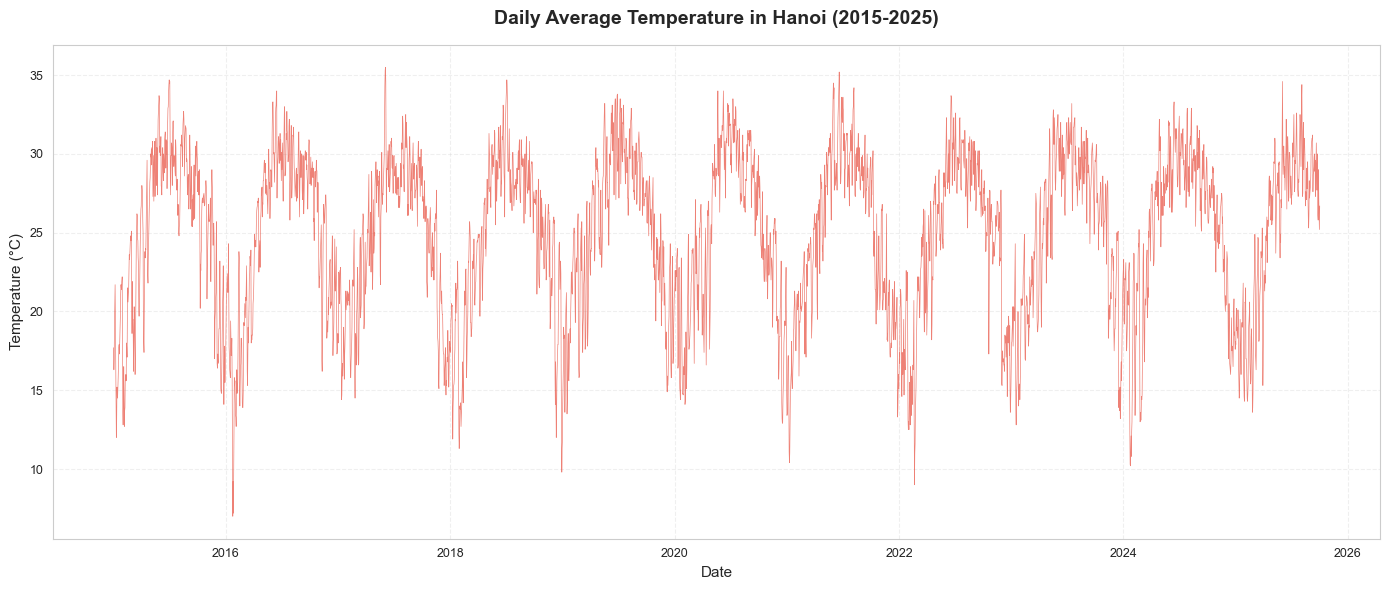

In [5]:
# Plot daily temperature over the entire time period
plt.figure(figsize=(14, 6))
plt.plot(daily_data.index, daily_data['temp'], color='#E74C3C', alpha=0.7, linewidth=0.5)
plt.title('Daily Average Temperature in Hanoi (2015-2025)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Date', fontsize=11)
plt.ylabel('Temperature (°C)', fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

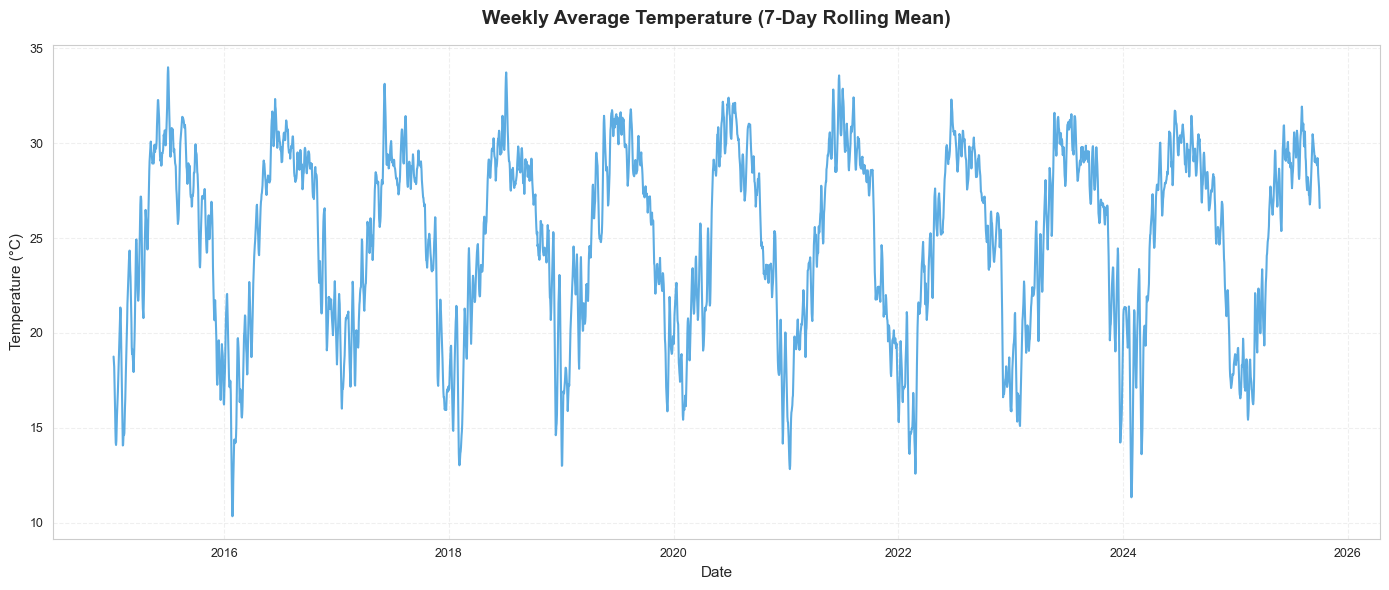

In [6]:
# Plot 7-day rolling average to smooth out daily variations
plt.figure(figsize=(14, 6))
weekly_temp = daily_data['temp'].rolling(window=7).mean()
plt.plot(daily_data.index, weekly_temp, color='#3498DB', alpha=0.8, linewidth=1.5)
plt.title('Weekly Average Temperature (7-Day Rolling Mean)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Date', fontsize=11)
plt.ylabel('Temperature (°C)', fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

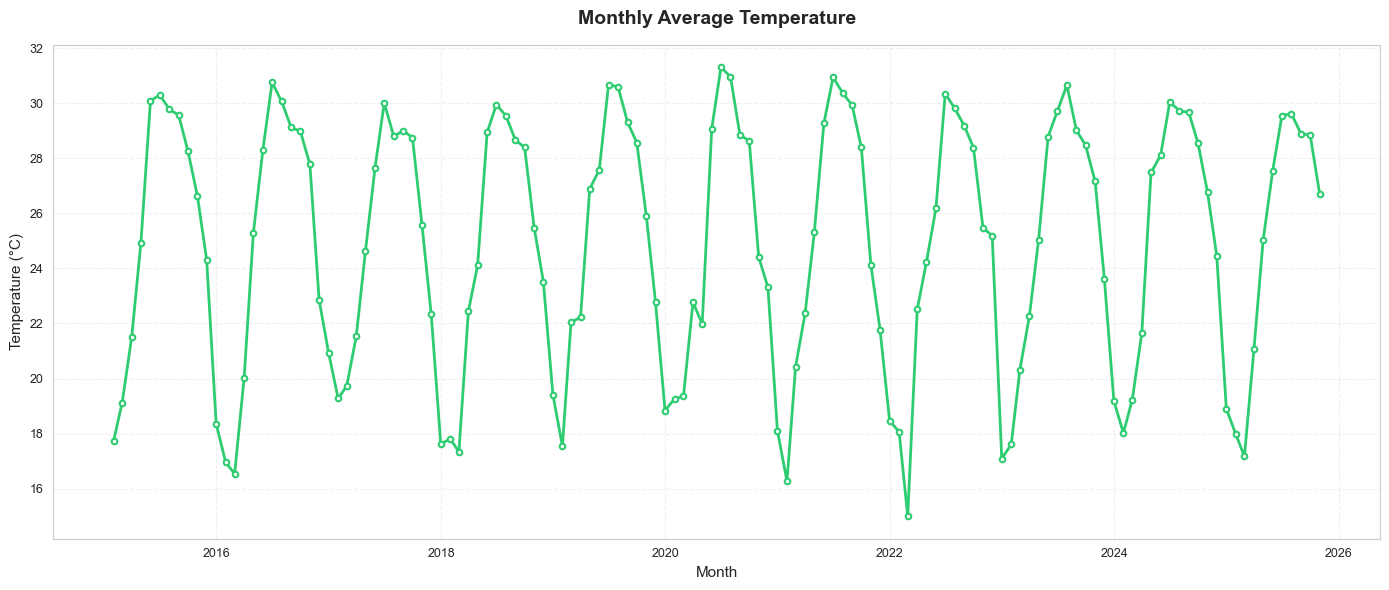

In [7]:
# Plot monthly average temperature to see seasonal patterns clearly
plt.figure(figsize=(14, 6))
monthly_temp = daily_data['temp'].resample('M').mean()
plt.plot(monthly_temp.index, monthly_temp.values, color='#2ECC71', linewidth=2, marker='o', markersize=4, markerfacecolor='white', markeredgewidth=1.5)
plt.title('Monthly Average Temperature', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Month', fontsize=11)
plt.ylabel('Temperature (°C)', fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

We have several observations about Hanoi's weather trend.

**Seasonal Cycles and Temperature Fluctuation**: The most prominent feature of the graphs is the distinct and highly regular cyclical pattern that repeats annually. This cycle corresponds directly to Hanoi's four distinct seasons:
   - Summer: The peak of each wave represents the summer season, typically occurring from May to August. During this period, the average daily temperature consistently reaches its highest point, generally ranging from 30°C to 35°C. The absolute hottest days are marked by the sharp peaks within this broader wave.
   - Winter: The lowest points, or troughs, in the graph signify the winter months, usually from December to February. Average daily temperatures during this time drop significantly, hovering between 15°C and 20°C, with the coldest days dipping below 10°C.
   - Spring and Autumn: The periods of rapid temperature change between the summer highs and winter lows represent the transitional seasons of spring (roughly March-April) and autumn (roughly September-November). The graph shows a steep incline in temperature during spring and a sharp decline in autumn.

**Long-Term Trends and Consistency**: Observing the peaks and troughs across the entire 10-year span, there is no dramatic, sustained long-term warming or cooling trend immediately visible from this chart. The maximum summer temperatures and minimum winter temperatures appear to fluctuate from year to year but generally return to a consistent range. Each year's temperature profile closely mirrors the last, highlighting the predictable nature of Hanoi's climate. 

**Key Observations**: Temperature Range: The data shows a wide annual temperature range of approximately 25°C, from the coldest winter nights (below 10°C) to the hottest summer days (around 35°C).

**Volatility**: Within the broader seasonal waves, there is considerable short-term fluctuation. This represents the day-to-day weather variations, such as cooler, rainy days during the summer or brief warmer spells in the winter.

In summary, the graph effectively illustrates the classic humid subtropical climate of Hanoi, characterized by hot, humid summers and cool, dry winters. The consistency of the pattern over the last decade provides a reliable picture of the city's typical weather year.


**Temperature and Dew Point Relationship**

Below is a ribbon chart showing the relationship between average temperature and dew point over time. The shaded area between the two lines represents the difference, which indicates how close the air is to saturation.

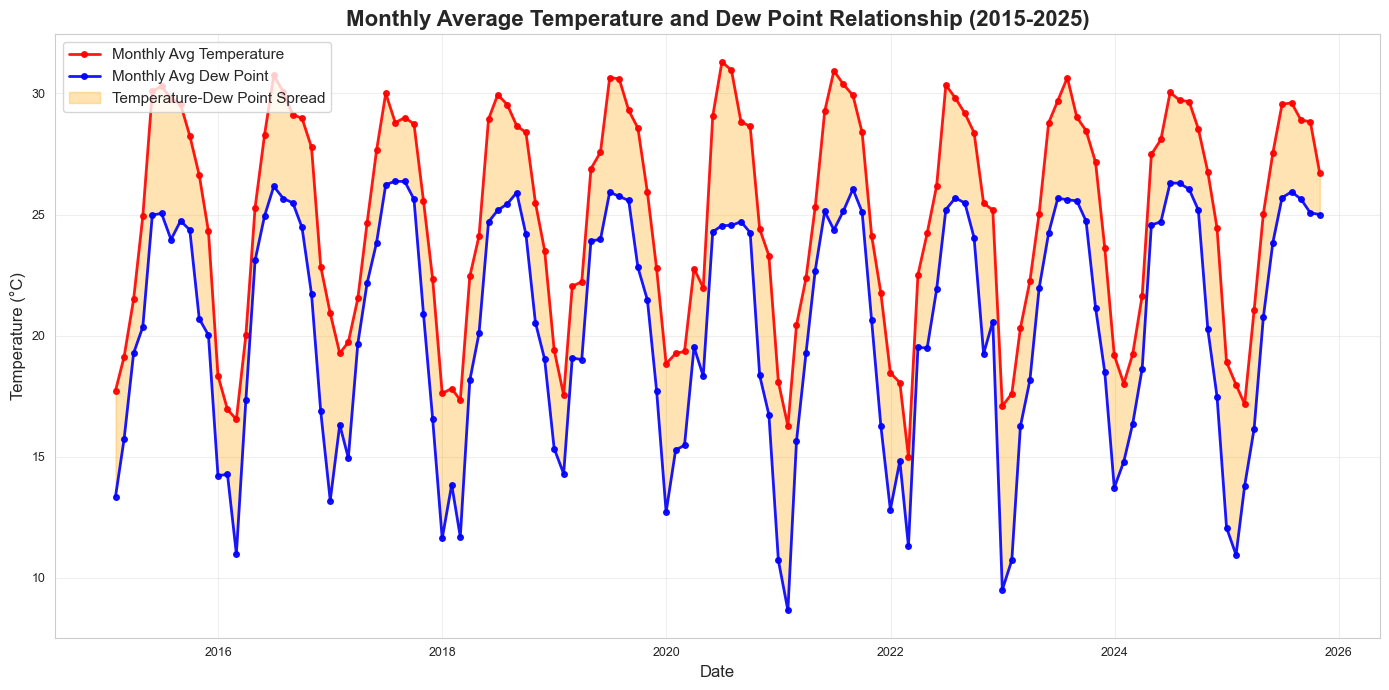

In [8]:
# Create ribbon chart for Temperature and Dew Point using monthly averages
# Resample to monthly averages for cleaner visualization
monthly_temp_dew = daily_data[['temp', 'dew']].resample('M').mean()

plt.figure(figsize=(14, 7))

# Plot temperature and dew point lines
plt.plot(monthly_temp_dew.index, monthly_temp_dew['temp'], color='red', alpha=0.9, 
         linewidth=2, label='Monthly Avg Temperature', marker='o', markersize=4)
plt.plot(monthly_temp_dew.index, monthly_temp_dew['dew'], color='blue', alpha=0.9, 
         linewidth=2, label='Monthly Avg Dew Point', marker='o', markersize=4)

# Fill the area between the two lines
plt.fill_between(monthly_temp_dew.index, monthly_temp_dew['temp'], monthly_temp_dew['dew'], 
                 alpha=0.3, color='orange', label='Temperature-Dew Point Spread')

plt.title('Monthly Average Temperature and Dew Point Relationship (2015-2025)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The monthly average ribbon chart above clearly visualizes the close relationship between temperature and dew point over the 10-year period. We have some key observations:

**Strong Correlation**: The smoothed monthly lines show that temperature and dew point follow nearly identical seasonal patterns, confirming their strong positive correlation.

**Clear Seasonal Cycles**: The monthly aggregation reveals distinct annual cycles:
   - **Summer peaks (May-August)**: Monthly average temperatures reach 28-30°C with dew points around 24-26°C
   - **Winter troughs (December-February)**: Monthly averages drop to 16-18°C for temperature and 12-14°C for dew point
   - The consistent year-over-year pattern demonstrates Hanoi's predictable subtropical climate

**Temperature-Dew Point Spread (Orange Ribbon)**:
   - The shaded area represents the monthly average difference between temperature and dew point
   - **Narrower spread**: Indicates air closer to saturation (higher relative humidity)
   - **Wider spread**: Indicates drier air (lower relative humidity)
   - The spread is consistently narrower during summer months, reflecting Hanoi's high humidity season

**Smooth Seasonal Transitions**: The monthly averages show gradual transitions between seasons, with spring (March-May) showing steady warming and autumn (September-November) showing gradual cooling for both variables.

#### **Data Splitting Strategy**

For time-series forecasting, we use **chronological splitting** to prevent data leakage and simulate real-world forecasting scenarios.

We will then begin to split the data into 3 sets: training set, development (validation) set and test set.

In [9]:
# Split data chronologically for time series
# Use 70% for training, 15% for validation (dev), 15% for testing
train_size = int(len(daily_data) * 0.7)
dev_size = int(len(daily_data) * 0.15)

# Split the data chronologically
train_data = daily_data.iloc[:train_size]
dev_data = daily_data.iloc[train_size:train_size + dev_size]
test_data = daily_data.iloc[train_size + dev_size:]

print(f"Training set: {train_data.index[0]} to {train_data.index[-1]} ({len(train_data)} samples)")
print(f"Development set: {dev_data.index[0]} to {dev_data.index[-1]} ({len(dev_data)} samples)")
print(f"Test set: {test_data.index[0]} to {test_data.index[-1]} ({len(test_data)} samples)")

Training set: 2015-01-01 00:00:00 to 2022-07-10 00:00:00 (2748 samples)
Development set: 2022-07-11 00:00:00 to 2024-02-19 00:00:00 (589 samples)
Test set: 2024-02-20 00:00:00 to 2025-10-01 00:00:00 (590 samples)


Based on the splits, we can see that:
- The training set contains all records from January 1, 2015 to July 10, 2022
- The development set contains all records from July 11, 2022 to February 19, 2024.
- Finally, the rest belongs to the test set.

#### **Exploratory Data Analysis**

Now we dive deep into the training set to understand patterns, distributions, and relationships in the data.

##### **Univariate Analysis**

Examining the distribution and characteristics of individual weather variables.

**Missing Value Analysis**: Examine the missing data patterns in our training set before visualizing the distributions.

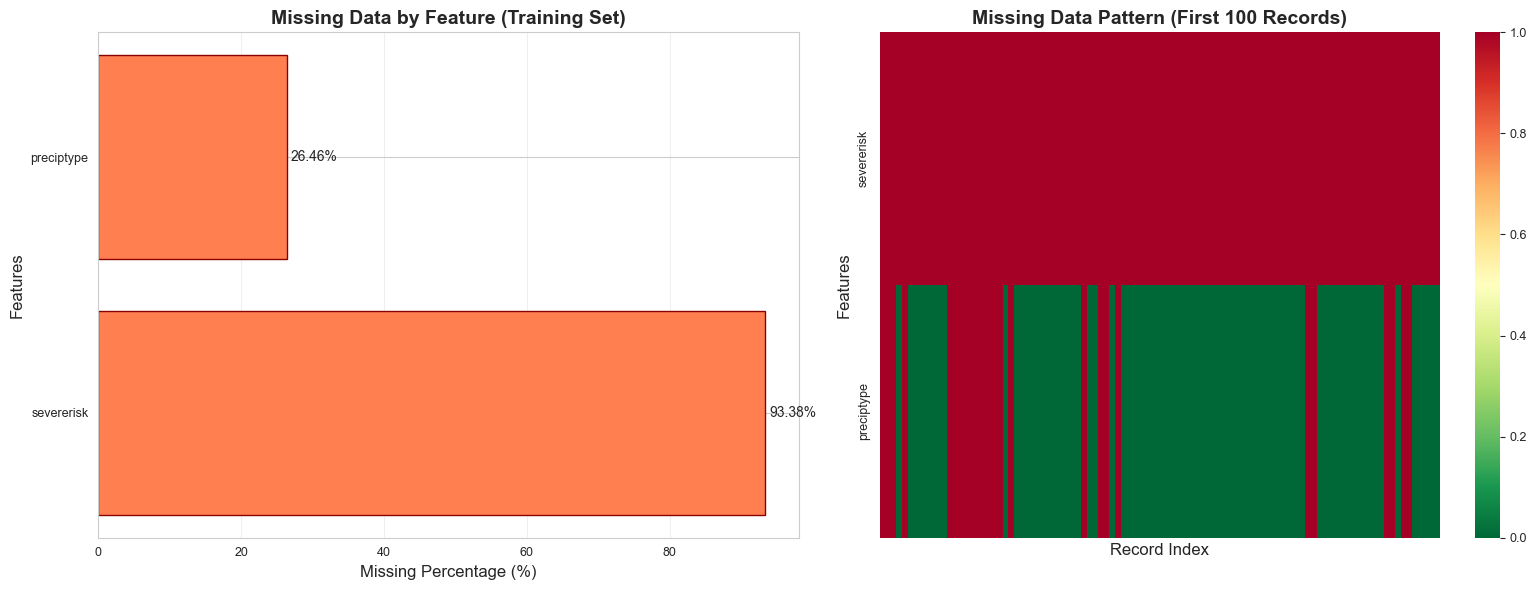

In [10]:
# Calculate missing values for each column
missing_data = pd.DataFrame({
    'Column': train_data.columns,
    'Missing_Count': train_data.isnull().sum(),
    'Missing_Percentage': (train_data.isnull().sum() / len(train_data) * 100).round(2)
})

# Sort by missing percentage
missing_data = missing_data.sort_values('Missing_Percentage', ascending=False)

# Filter to show only columns with missing values
missing_data_filtered = missing_data[missing_data['Missing_Count'] > 0]

# Visualize missing data
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of missing percentages
if len(missing_data_filtered) > 0:
    axes[0].barh(missing_data_filtered['Column'], missing_data_filtered['Missing_Percentage'], 
                 color='coral', edgecolor='darkred')
    axes[0].set_xlabel('Missing Percentage (%)', fontsize=12)
    axes[0].set_ylabel('Features', fontsize=12)
    axes[0].set_title('Missing Data by Feature (Training Set)', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # Add percentage labels
    for i, (col, pct) in enumerate(zip(missing_data_filtered['Column'], 
                                        missing_data_filtered['Missing_Percentage'])):
        axes[0].text(pct + 0.5, i, f'{pct}%', va='center', fontsize=10)
else:
    axes[0].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', 
                 fontsize=14, fontweight='bold')
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)
    axes[0].axis('off')

# Heatmap of missing data pattern (sample)
# Show a sample of rows to visualize patterns
sample_size = min(100, len(train_data))
sample_data = train_data.head(sample_size)
missing_matrix = sample_data.isnull().astype(int)

# Only show columns with missing values
if len(missing_data_filtered) > 0:
    cols_with_missing = missing_data_filtered['Column'].tolist()
    missing_matrix_filtered = missing_matrix[cols_with_missing]
    
    sns.heatmap(missing_matrix_filtered.T, cmap='RdYlGn_r', cbar=True, 
                yticklabels=cols_with_missing, xticklabels=False, ax=axes[1])
    axes[1].set_title(f'Missing Data Pattern (First {sample_size} Records)', 
                      fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Record Index', fontsize=12)
    axes[1].set_ylabel('Features', fontsize=12)
else:
    axes[1].text(0.5, 0.5, 'No Missing Values\nto Display', ha='center', va='center', 
                 fontsize=14, fontweight='bold')
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)
    axes[1].axis('off')

plt.tight_layout()
plt.show()

The missing value analysis reveals important patterns in our training dataset:

**`preciptype` - High Missing Rate**: 26.46% of this feature's values are missing . This is **not a data quality issue** but rather a **logical pattern**. Precipitation type is only recorded when precipitation actually occurs (precip > 0). On dry days with no rainfall, this field naturally remains empty. This aligns with our earlier observation that most days in the dataset have zero precipitation.

**`severerisk` - Missing Values**: The severe risk indicator also has missing values. This could be due to:
   - The metric only being calculated during certain weather conditions
   - Data collection limitations during the historical period
   - The field may have been introduced later in the data collection timeline

**Other Features - Complete Data**: The vast majority of our features (temperature, humidity, wind, pressure, solar radiation, etc.) have complete data with no missing values. This indicates **high data quality** for the core meteorological measurements.

**Implications for Modeling**
- For `preciptype`: We can either create a "No Precipitation" category for missing values, or use this as a binary feature (precipitation occurred: yes/no)
- For `severerisk`: We may need to either impute values, drop this feature, or create a separate model that only uses records where this value is available
- The complete data for core weather variables means we can proceed with analysis and modeling without extensive data cleaning or imputation for most features

This pattern of missing values is **expected and acceptable** for weather data, where certain measurements are conditional on specific weather events occurring.

**Distribution Plots**

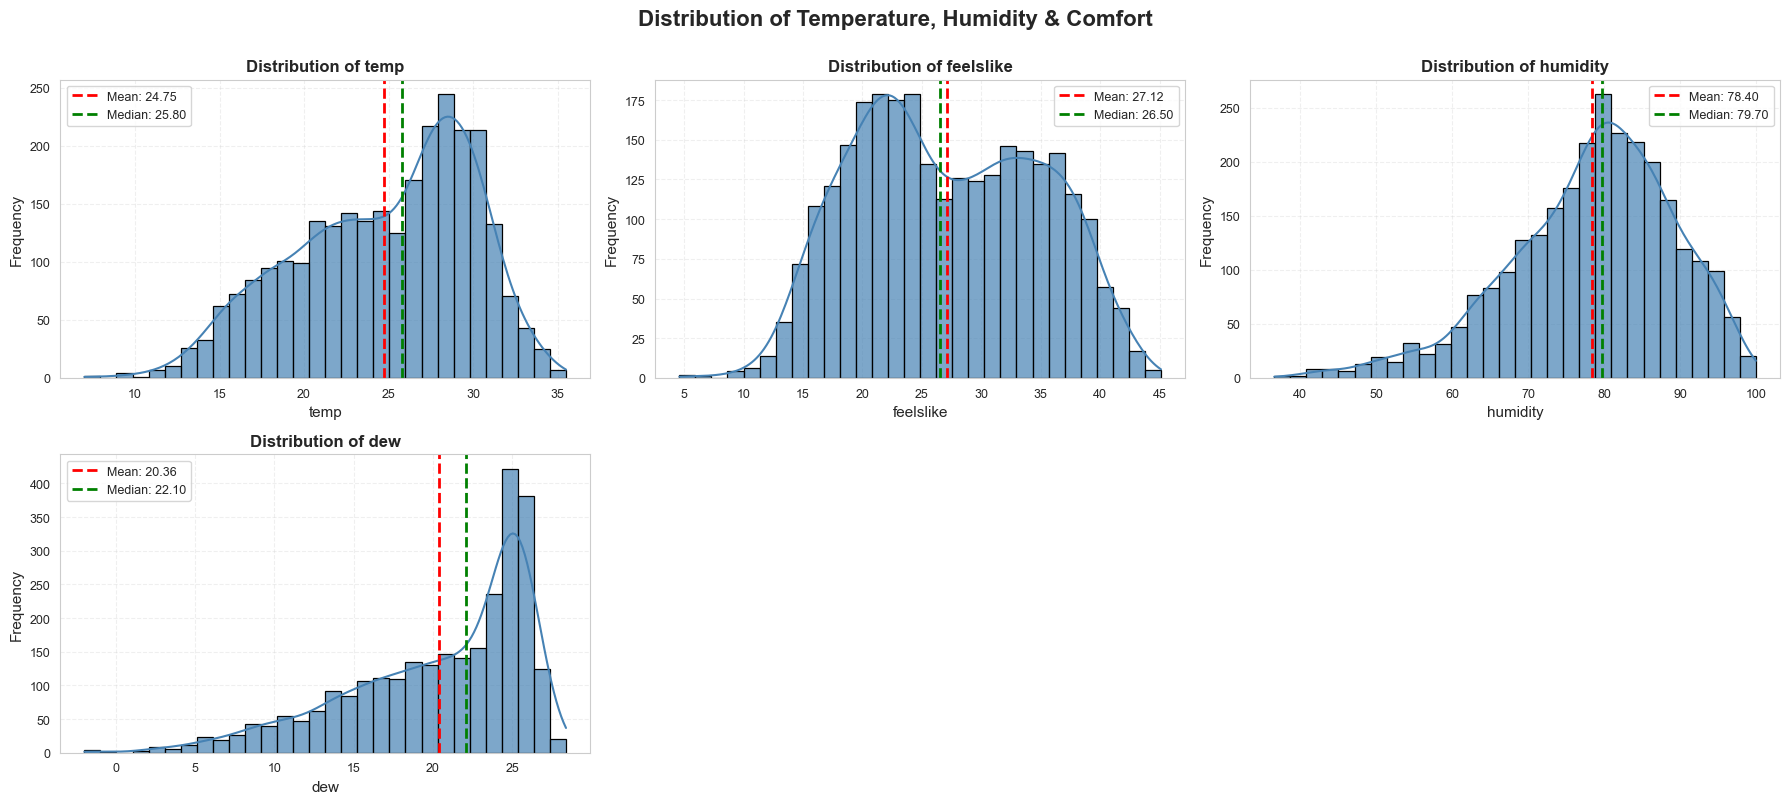

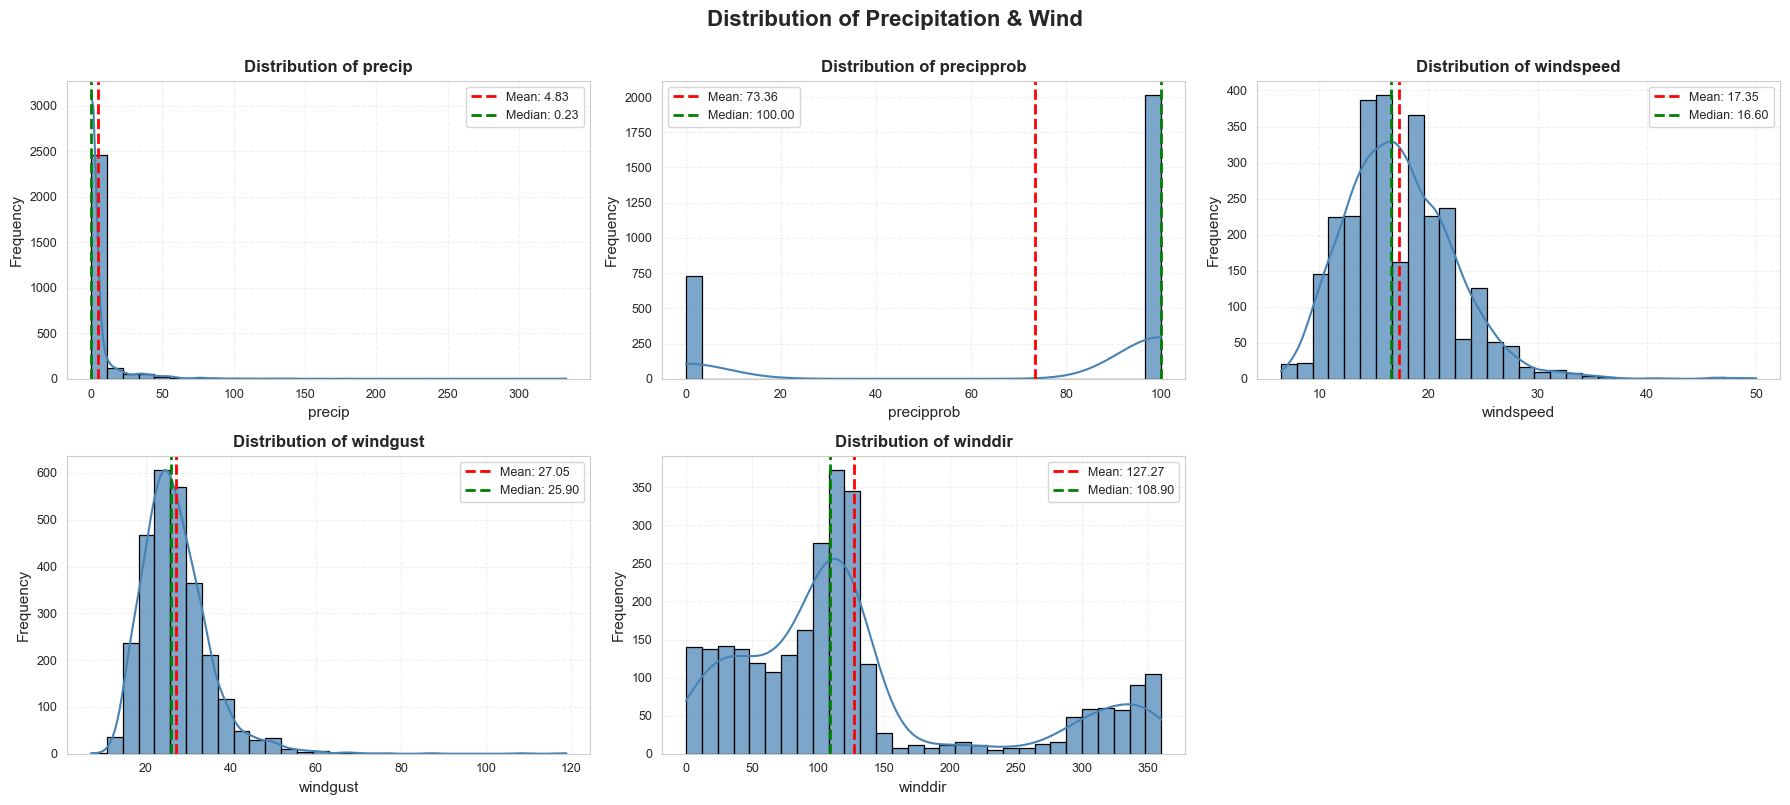

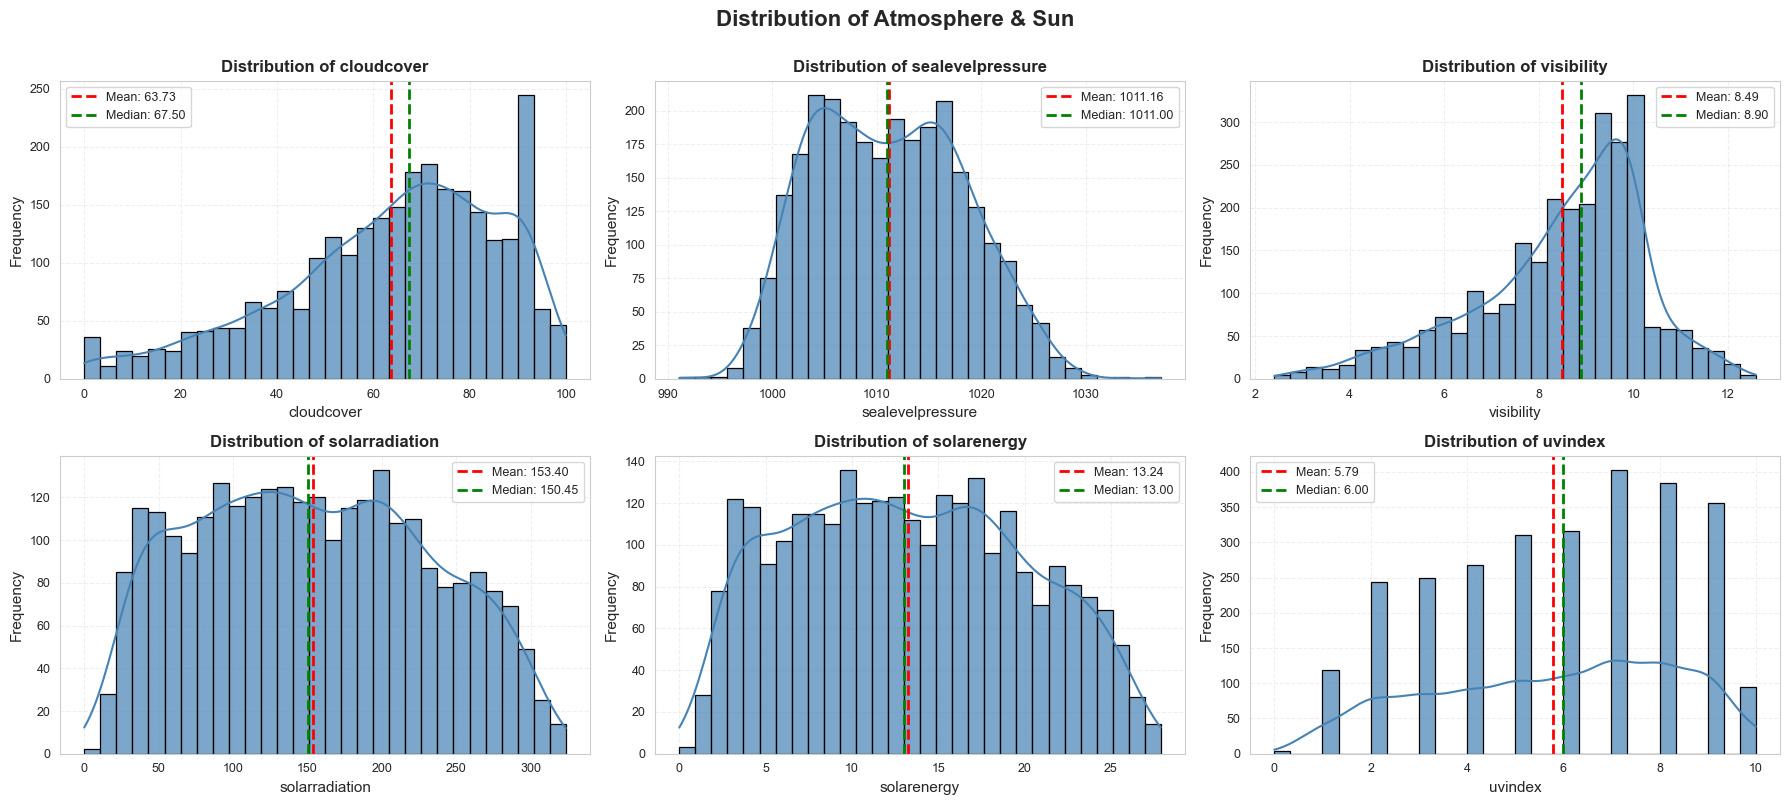

In [11]:
# Group variables by category based on their meteorological relationship
variable_groups = {
    'Temperature, Humidity & Comfort': ['temp', 'feelslike', 'humidity', 'dew'],
    'Precipitation & Wind': ['precip', 'precipprob', 'windspeed', 'windgust', 'winddir'],
    'Atmosphere & Sun': ['cloudcover', 'sealevelpressure', 'visibility', 'solarradiation', 'solarenergy', 'uvindex']
}

# Create separate figure for each group
for group_name, variables in variable_groups.items():
    # Filter to only include variables that exist in the dataset
    available_vars = [var for var in variables if var in train_data.columns]
    
    if not available_vars:
        continue
    
    # Determine grid layout
    n_vars = len(available_vars)
    n_cols = min(3, n_vars)  # Max 3 columns
    n_rows = (n_vars + n_cols - 1) // n_cols  # Ceiling division
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
    fig.suptitle(f'Distribution of {group_name}', fontsize=16, fontweight='bold', y=1.00)
    
    # Flatten axes array for easier iteration
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes_flat = axes.flatten() if n_vars > 1 else [axes]
    
    # Plot each variable
    for idx, var in enumerate(available_vars):
        ax = axes_flat[idx]
        
        # Create histogram with KDE
        sns.histplot(train_data[var], bins=30, kde=True, color='steelblue', 
                    edgecolor='black', alpha=0.7, ax=ax)
        
        # Customize
        ax.set_title(f'Distribution of {var}', fontsize=12, fontweight='bold')
        ax.set_xlabel(var, fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Add mean and median lines
        mean_val = train_data[var].mean()
        median_val = train_data[var].median()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
        ax.legend(fontsize=9)
    
    # Hide unused subplots
    for idx in range(n_vars, len(axes_flat)):
        axes_flat[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()


**Temperature, Humidity & Comfort**: This group tells the story of what the weather "feels like."

Distribution of `temp` (Temperature): This is a classic bimodal distribution. It doesn't have one single "average" temperature. Instead, it has two peaks:
- A large peak around 28-30°C (the hot season).
- A smaller, but significant, peak around 20-22°C (the cool season).

Days below 10°C or above 35°C are rare.

Distribution of `feelslike`: This is also bimodal and follows the `temp` chart, but the hot-season peak is shifted much higher, clustering around 35-37°C. This indicates that during the hot season, the humidity makes it feel significantly hotter than the actual air temperature.

Distribution of `humidity`: This is left-skewed. The vast majority of days have high humidity, with the peak frequency being around 80-85%. Very dry days (e.g., < 50% humidity) are uncommon.

Distribution of `dew` (Dew Point): This is right-skewed, with a large peak around 25°C. A high dew point like this corresponds to very "muggy" and "tropical" air. This, combined with the humidity chart, confirms that Hanoi's climate is predominantly very humid.


**Precipitation & Wind**: This group describes rain and air movement.

Distribution of `precip` (Precipitation): This is extremely right-skewed, with a massive spike at 0. This means the overwhelming majority of days have no rain. The long tail to the right shows that on the days it does rain, it can be very heavy (with some days seeing over 200-300mm).

Distribution of `precipprob` (Precipitation Probability): This is a U-shaped or bimodal distribution at its extremes. Most days have either a very low probability (near 0%) or a very high probability (around 80-100%) of rain. There are relatively few days with an ambiguous 40-60% chance. This suggests the weather is often "all or nothing"—it's either a clear dry day or a definite wet day.

Distribution of `windspeed` & `windgust`: Both are right-skewed, peaking at low values. This means most days are calm. The average wind speed is typically low (peaking around 7-10 km/h), though occasional gusts (storms) are visible in the `windgust` tail.

Distribution of `winddir` (Wind Direction): This is strongly bimodal. There are two dominant wind directions:
- One peak is around 50-70 degrees (East-Northeast).
- The other, larger peak is around 100-120 degrees (East-Southeast).

Wind almost never comes from the West.


**Atmosphere & Sun**: This group describes cloudiness, pressure, and solar energy.

Distribution of `cloudcover`: This is another bimodal distribution. Days are most often either very overcast (peak at 80-90% cloud cover) or relatively clear (smaller peak at 10-20%). "Partly cloudy" (50-60%) days are less common.

Distribution of `sealevelpressure`: This is also bimodal, suggesting two dominant pressure systems, likely corresponding to the two main seasons. One regime is around 1005-1010 mbar, and the other is at a higher pressure of 1015-1018 mbar.

Distribution of `visibility`: This is left-skewed, peaking at the high end (10-12 km). This means that, on average, visibility is quite good. Days with poor visibility (< 4 km) do occur but are not the norm.

Distribution of `solarradiation` & `solarenergy`: These have very broad, flat "plateau" distributions. This means there is a wide variety of solar energy levels, which makes sense given the bimodal cloud cover (you have many very cloudy days with low energy and many clear days with high energy).

Distribution of `uvindex`: This is a very interesting multimodal/uniform distribution. Unlike the others, there isn't one strong peak. Instead, many different UV levels (from 1 to 9) are common. The single most frequent value is 9, indicating that "very high" UV exposure is a very common occurrence.

This seasonal split is the driving factor visible in the bimodal (two-peak) distributions for `temp`, `feelslike`, `sealevelpressure`, `winddir`, and `cloudcover`.

**Categorical Variables Analysis**: Examine the distribution of categorical variables in the dataset.

Categorical columns to visualize: ['preciptype', 'conditions', 'description', 'icon']


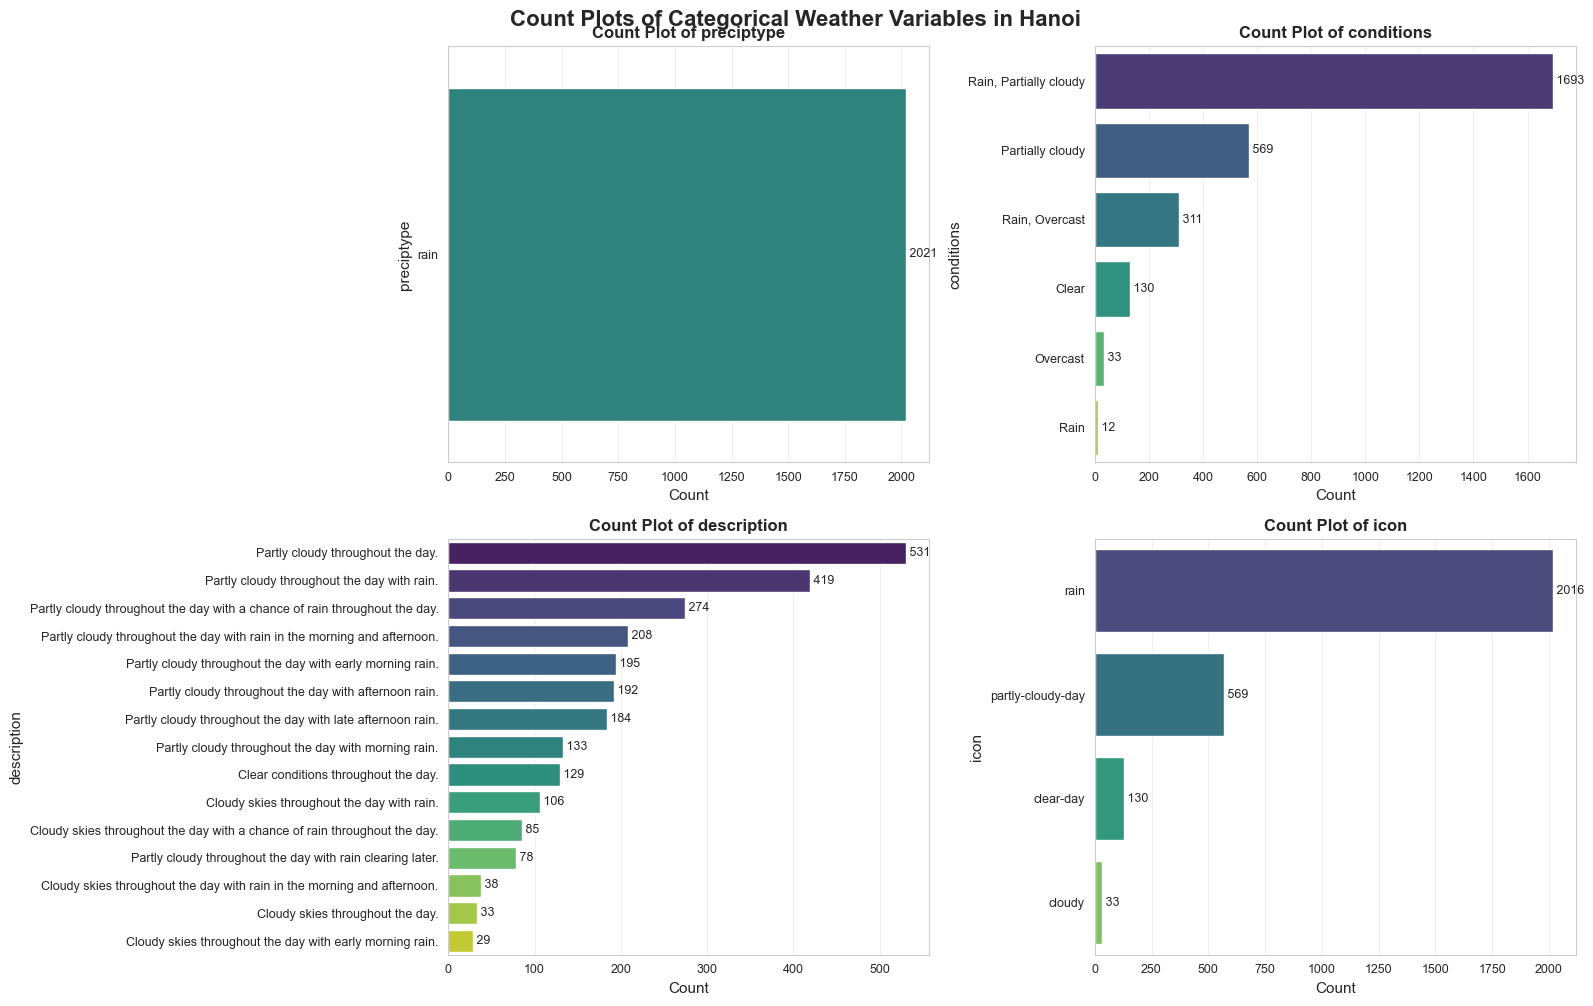

In [12]:
# Select categorical columns
categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()

# Remove columns that are not useful for count plots (stations, source, name, sunrise, sunset)
# Keep description to analyze weather descriptions
cols_to_exclude = ['stations', 'name', 'sunrise', 'sunset', 'source']
categorical_cols = [col for col in categorical_cols if col not in cols_to_exclude]

print(f"Categorical columns to visualize: {categorical_cols}")

# Create subplots for categorical variables
n_cols = 2  # Number of columns in the grid
n_rows = int(np.ceil(len(categorical_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

# Plot count plot for each categorical column
for idx, col in enumerate(categorical_cols):
    # Get value counts and filter out NaN
    value_counts = train_data[col].value_counts()
    
    # For description field, show only top 15 to keep plot readable
    if col == 'description':
        value_counts = value_counts.head(15)
    
    # Create count plot
    sns.countplot(data=train_data, y=col, order=value_counts.index, 
                  ax=axes[idx], palette='viridis')
    axes[idx].set_title(f"Count Plot of {col}", fontsize=12, fontweight='bold')
    axes[idx].set_xlabel("Count")
    axes[idx].set_ylabel(col)
    axes[idx].grid(True, alpha=0.3, axis='x')
    
    # Add value counts as text
    for i, (category, count) in enumerate(value_counts.items()):
        axes[idx].text(count, i, f' {count}', va='center', fontsize=9)

# Hide unused subplots
for idx in range(len(categorical_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle("Count Plots of Categorical Weather Variables in Hanoi", 
             fontsize=16, fontweight='bold', y=1.001)
plt.show()

The count plots reveal important patterns in Hanoi's weather conditions:

**Precipitation Type (`preciptype`)**

- **Rain Dominates**: The overwhelming majority of precipitation events in Hanoi are classified as "rain," which is expected given the city's tropical monsoon climate.
- **Missing Values**: A significant portion of the data has no `preciptype` value, which corresponds to the many dry days observed in the precipitation distribution. This makes sense—when there's no precipitation (precip = 0), the type is not recorded.
- **Snow is Virtually Non-existent**: As expected for a subtropical climate, snow events are extremely rare or completely absent in Hanoi. The city's average temperature (24.9°C) and minimum recorded temperature (7°C) make snowfall highly unlikely.

**Weather Conditions (`conditions`)**

The conditions variable provides a more nuanced view of daily weather:

- **"Partially Cloudy" is Most Common**: This is the most frequent weather condition, reflecting the moderate cloud cover (mean ~64%) observed in the numeric data. This condition often occurs during transitional periods and represents typical days without extreme weather.

- **"Rain, Partially Cloudy"**: This combination is the second most common, indicating that rainy days in Hanoi often still have partial cloud cover rather than completely overcast skies. This is characteristic of tropical convective rainfall patterns.

- **"Overcast"**: Completely overcast days are also frequent, aligning with the high cloud cover peaks (80-90%) observed in the distribution plots. These days typically occur during the monsoon season.

- **"Rain, Overcast"**: Heavy rainfall events typically occur with fully overcast conditions, representing the intense monsoon rainfall characteristic of the region.

- **Clear Days are Rare**: Conditions like "Clear" appear much less frequently, confirming that Hanoi experiences high humidity and frequent cloud cover throughout the year.

- **Storm Events**: Conditions mentioning "thunderstorms" appear in the data, though less frequently. These correspond to the convective storms common in tropical regions, particularly during the hot, humid summer months.

**Weather Icon (`icon`)**

The weather icon categories provide a simplified classification system:

- **"Rain" Icon Dominates**: The most common icon type is "rain," consistent with Hanoi's high annual precipitation and the fact that 72% of days have some probability of precipitation.

- **"Partly-Cloudy-Day"**: This is the second most common icon, representing the typical tropical weather pattern with mixed sun and clouds.

- **"Cloudy"**: Fully cloudy days without precipitation are also common, reflecting the high baseline cloud cover in the region.

- **"Clear-Day" is Less Common**: Clear, sunny days are relatively rare in Hanoi due to the persistently high humidity and frequent cloud formation.

- **Nighttime Icons**: The presence of "partly-cloudy-night", "clear-night", and "rain-night" icons indicates that the data captures weather conditions throughout the full 24-hour cycle, which is important for comprehensive weather analysis.

**Weather Description (`description`)**

The description field provides detailed natural language summaries of daily weather (showing top 15 most common):

- **Rich Textual Information**: Descriptions combine multiple weather elements into comprehensive summaries like "Partly cloudy throughout the day" or "Becoming cloudy in the afternoon with late afternoon rain."

- **Pattern Diversity**: Unlike the structured `conditions` field, descriptions show high variability with many unique combinations, reflecting the nuanced nature of weather patterns.

- **Temporal Details**: Many descriptions include time-of-day information (e.g., "afternoon rain", "morning fog", "evening clouds"), providing temporal context not captured in daily aggregate metrics.

- **Compound Conditions**: Descriptions often describe weather transitions throughout the day (e.g., "Clear in the morning, becoming cloudy in the afternoon"), which is valuable for understanding intra-day weather dynamics.

- **Most Common Patterns**: The most frequent descriptions typically mention "partly cloudy", "cloudy throughout the day", and various rain patterns, consistent with Hanoi's monsoon-influenced climate.

- **Modeling Potential**: While too diverse for direct use as categorical features, description text could be valuable for:
  - Natural language processing (NLP) to extract weather events
  - Training text-based weather prediction models
  - Validating consistency with other structured fields

**Key Insights from Categorical Analysis:**

- **Monsoon Influence**: The distribution of weather conditions strongly reflects Hanoi's monsoon climate, with rain being the predominant feature during certain seasons.

- **Data Quality**: The presence of missing values in `preciptype` is not a data quality issue but rather a logical consequence—precipitation type is only recorded when precipitation occurs.

- **Weather Predictability**: The distinct categories and their frequencies suggest relatively predictable seasonal patterns. Weather conditions tend to fall into clear categories (rainy vs. dry, clear vs. cloudy) rather than ambiguous middle states.

- **Tropical Climate Confirmation**: All four categorical variables confirm the tropical/subtropical nature of Hanoi's climate: frequent rainfall, high cloud cover, warm temperatures, and the complete absence of winter weather phenomena like snow or ice.

- **Descriptive Richness**: The `description` field adds narrative context that complements the structured categorical and numeric data, potentially useful for advanced NLP-based forecasting approaches.

This categorical analysis complements the numeric distributions perfectly, painting a complete picture of Hanoi as a city with a humid subtropical climate characterized by hot, rainy summers and cooler, drier winters with persistent cloud cover year-round.

**Statistical Summary of Categorical Variables**: Quantify the distribution of categorical variables with percentages.

In [13]:
# Statistical summary for each categorical variable
categorical_cols_all = train_data.select_dtypes(include=['object']).columns.tolist()
cols_to_exclude = ['stations', 'name', 'sunrise', 'sunset', 'description', 'source']
categorical_cols_summary = [col for col in categorical_cols_all if col not in cols_to_exclude]

print("="*80)
print("CATEGORICAL VARIABLES STATISTICAL SUMMARY")
print("="*80)

for col in categorical_cols_summary:
    print(f"\n{'='*80}")
    print(f"Variable: {col.upper()}")
    print(f"{'='*80}")
    
    # Get value counts
    value_counts = train_data[col].value_counts()
    total_count = len(train_data)
    missing_count = train_data[col].isna().sum()
    
    # Create a summary dataframe
    summary_df = pd.DataFrame({
        'Category': value_counts.index,
        'Count': value_counts.values,
        'Percentage': (value_counts.values / total_count * 100).round(2)
    })
    
    print(f"\nTotal Records: {total_count}")
    print(f"Non-Missing Values: {total_count - missing_count} ({((total_count - missing_count) / total_count * 100):.2f}%)")
    print(f"Missing Values: {missing_count} ({(missing_count / total_count * 100):.2f}%)")
    print(f"Unique Categories: {len(value_counts)}")
    print(f"\nTop 10 Categories:")
    print(summary_df.head(10).to_string(index=False))

# Special handling for description field (too many unique values)
print(f"\n{'='*80}")
print(f"Variable: DESCRIPTION (Text Field)")
print(f"{'='*80}")
description_counts = train_data['description'].value_counts()
total_count = len(train_data)
missing_count = train_data['description'].isna().sum()

print(f"\nTotal Records: {total_count}")
print(f"Non-Missing Values: {total_count - missing_count} ({((total_count - missing_count) / total_count * 100):.2f}%)")
print(f"Missing Values: {missing_count} ({(missing_count / total_count * 100):.2f}%)")
print(f"Unique Descriptions: {len(description_counts)}")
print(f"\nTop 15 Most Common Descriptions:")
description_summary = pd.DataFrame({
    'Description': description_counts.head(15).index,
    'Count': description_counts.head(15).values,
    'Percentage': (description_counts.head(15).values / total_count * 100).round(2)
})
print(description_summary.to_string(index=False))
print(f"\nNote: Due to high variability ({len(description_counts)} unique descriptions),")
print(f"this field is best suited for NLP analysis rather than direct categorical encoding.")
    

CATEGORICAL VARIABLES STATISTICAL SUMMARY

Variable: PRECIPTYPE

Total Records: 2748
Non-Missing Values: 2021 (73.54%)
Missing Values: 727 (26.46%)
Unique Categories: 1

Top 10 Categories:
Category  Count  Percentage
    rain   2021       73.54

Variable: CONDITIONS

Total Records: 2748
Non-Missing Values: 2748 (100.00%)
Missing Values: 0 (0.00%)
Unique Categories: 6

Top 10 Categories:
              Category  Count  Percentage
Rain, Partially cloudy   1693       61.61
      Partially cloudy    569       20.71
        Rain, Overcast    311       11.32
                 Clear    130        4.73
              Overcast     33        1.20
                  Rain     12        0.44

Variable: ICON

Total Records: 2748
Non-Missing Values: 2748 (100.00%)
Missing Values: 0 (0.00%)
Unique Categories: 4

Top 10 Categories:
         Category  Count  Percentage
             rain   2016       73.36
partly-cloudy-day    569       20.71
        clear-day    130        4.73
           cloudy     33     

##### **Multivariate Analysis**

Exploring relationships between different weather variables to identify correlations and dependencies.

**Correlation Analysis:** See how different numerical variables relate to each other. 

We will not include `tempmax` and `tempmin`, as these attributes are collinear with `temp`.

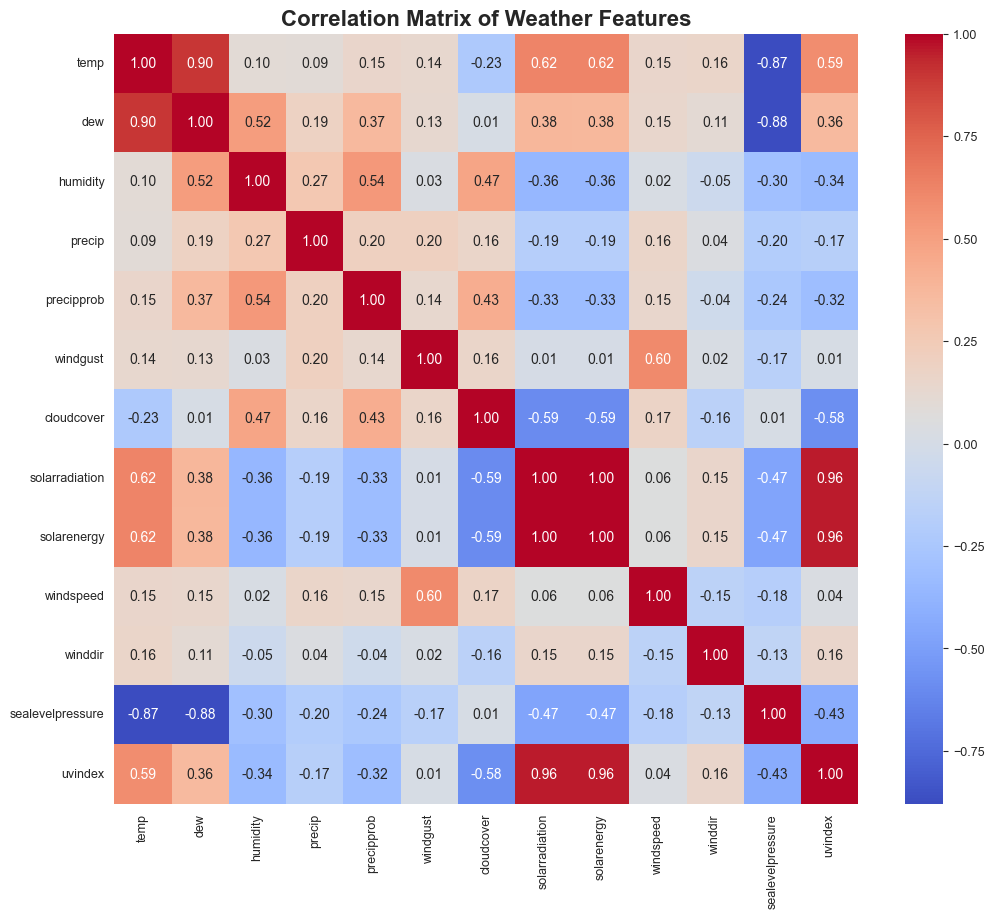

In [14]:
features = ["temp", "dew", "humidity", "precip", "precipprob", "windgust", "cloudcover", "solarradiation", "solarenergy", "windspeed", "winddir", "sealevelpressure", "uvindex"]
corr_matrix = daily_data[features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Weather Features", fontsize=16)
plt.show()

From the correlation heatmap, we can identify several important relationships:

**Strong Positive Correlations:**
- `temp` ↔ `dew`: Very strong positive correlation, indicating dew point rises with temperature
- `solarradiation` ↔ `solarenergy`: Nearly perfect correlation, as expected (energy is derived from radiation)
- `windspeed` ↔ `windgust`: Strong correlation, gusts occur with higher average wind speeds

**Strong Negative Correlations:**
- `cloudcover` ↔ `solarradiation`: Strong negative correlation, more clouds = less solar radiation
- `cloudcover` ↔ `uvindex`: Negative correlation, clouds block UV radiation
- `humidity` ↔ `temp`: Moderate negative correlation, higher temperatures can occur with lower humidity

**Weather Pattern Insights:**
- Temperature and humidity have complex seasonal relationships
- Precipitation variables show weak correlations with most features (precipitation is episodic)
- Wind patterns are relatively independent of temperature and moisture variables

These correlations will be important for feature selection in predictive modeling.

**Scatter Plot Analysis**: Visualize key relationships between variables using scatter plots.

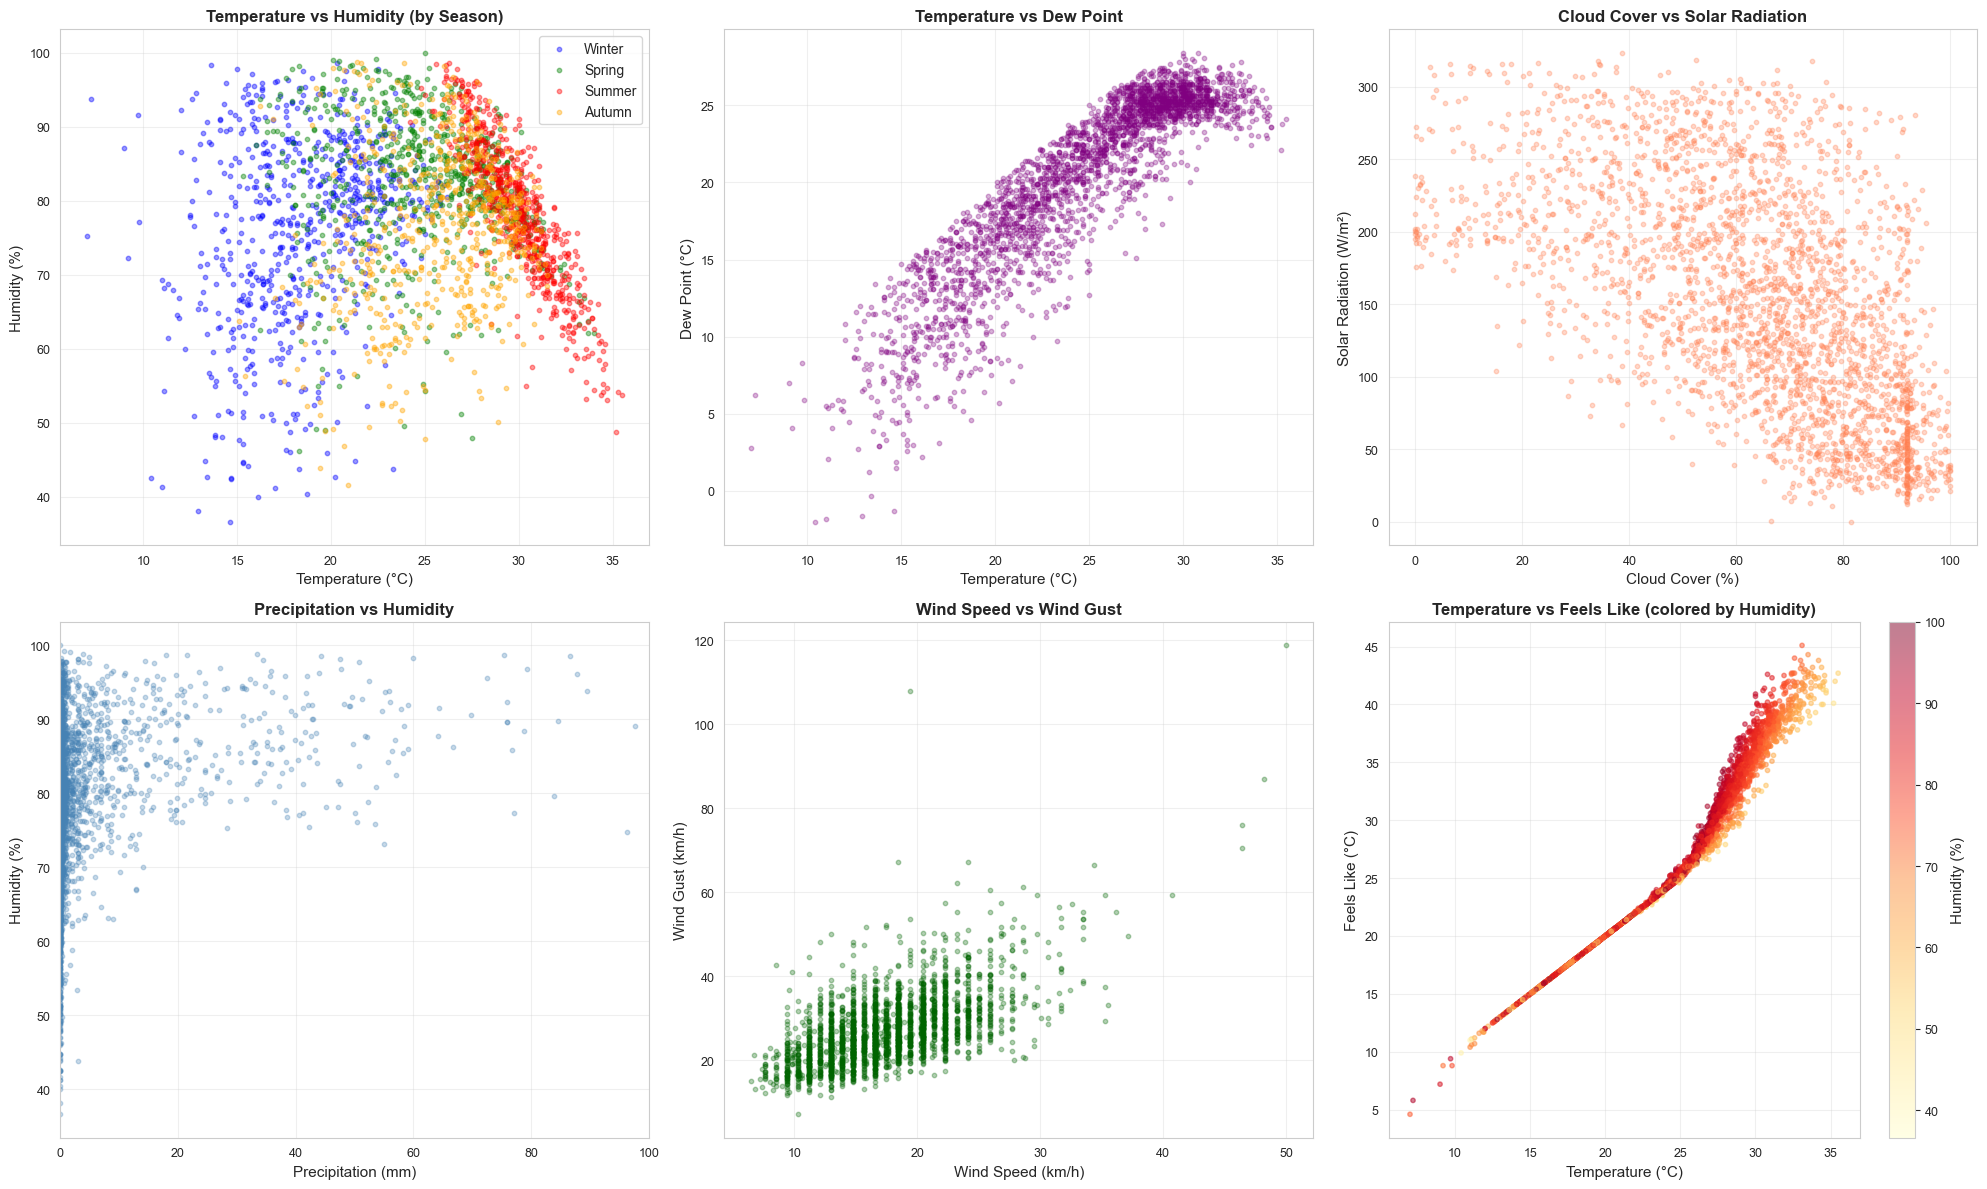

In [32]:
# Create scatter plots for key variable relationships
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Temperature vs Humidity (colored by season)
train_data['month'] = train_data.index.month
train_data['season'] = train_data['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] 
                                                   else 'Spring' if x in [3, 4, 5]
                                                   else 'Summer' if x in [6, 7, 8]
                                                   else 'Autumn')

for season, color in zip(['Winter', 'Spring', 'Summer', 'Autumn'], 
                         ['blue', 'green', 'red', 'orange']):
    season_data = train_data[train_data['season'] == season]
    axes[0, 0].scatter(season_data['temp'], season_data['humidity'], 
                      alpha=0.4, s=10, label=season, color=color)
axes[0, 0].set_xlabel('Temperature (°C)', fontsize=11)
axes[0, 0].set_ylabel('Humidity (%)', fontsize=11)
axes[0, 0].set_title('Temperature vs Humidity (by Season)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Temperature vs Dew Point
axes[0, 1].scatter(train_data['temp'], train_data['dew'], alpha=0.3, s=10, color='purple')
axes[0, 1].set_xlabel('Temperature (°C)', fontsize=11)
axes[0, 1].set_ylabel('Dew Point (°C)', fontsize=11)
axes[0, 1].set_title('Temperature vs Dew Point', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Cloud Cover vs Solar Radiation
axes[0, 2].scatter(train_data['cloudcover'], train_data['solarradiation'], 
                   alpha=0.3, s=10, color='coral')
axes[0, 2].set_xlabel('Cloud Cover (%)', fontsize=11)
axes[0, 2].set_ylabel('Solar Radiation (W/m²)', fontsize=11)
axes[0, 2].set_title('Cloud Cover vs Solar Radiation', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# 4. Precipitation vs Humidity
axes[1, 0].scatter(train_data['precip'], train_data['humidity'], 
                   alpha=0.3, s=10, color='steelblue')
axes[1, 0].set_xlabel('Precipitation (mm)', fontsize=11)
axes[1, 0].set_ylabel('Humidity (%)', fontsize=11)
axes[1, 0].set_title('Precipitation vs Humidity', fontsize=12, fontweight='bold')
axes[1, 0].set_xlim(0, 100)  # Limit x-axis for better visibility
axes[1, 0].grid(True, alpha=0.3)

# 5. Wind Speed vs Wind Gust
axes[1, 1].scatter(train_data['windspeed'], train_data['windgust'], 
                   alpha=0.3, s=10, color='darkgreen')
axes[1, 1].set_xlabel('Wind Speed (km/h)', fontsize=11)
axes[1, 1].set_ylabel('Wind Gust (km/h)', fontsize=11)
axes[1, 1].set_title('Wind Speed vs Wind Gust', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# 6. Temperature vs Feels Like (colored by humidity)
scatter = axes[1, 2].scatter(train_data['temp'], train_data['feelslike'], 
                            c=train_data['humidity'], cmap='YlOrRd', 
                            alpha=0.5, s=10)
axes[1, 2].set_xlabel('Temperature (°C)', fontsize=11)
axes[1, 2].set_ylabel('Feels Like (°C)', fontsize=11)
axes[1, 2].set_title('Temperature vs Feels Like (colored by Humidity)', 
                     fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 2], label='Humidity (%)')

plt.tight_layout()
plt.show()

**Box Plot Analysis by Categories:** Examine how numeric variables vary across categorical weather conditions.

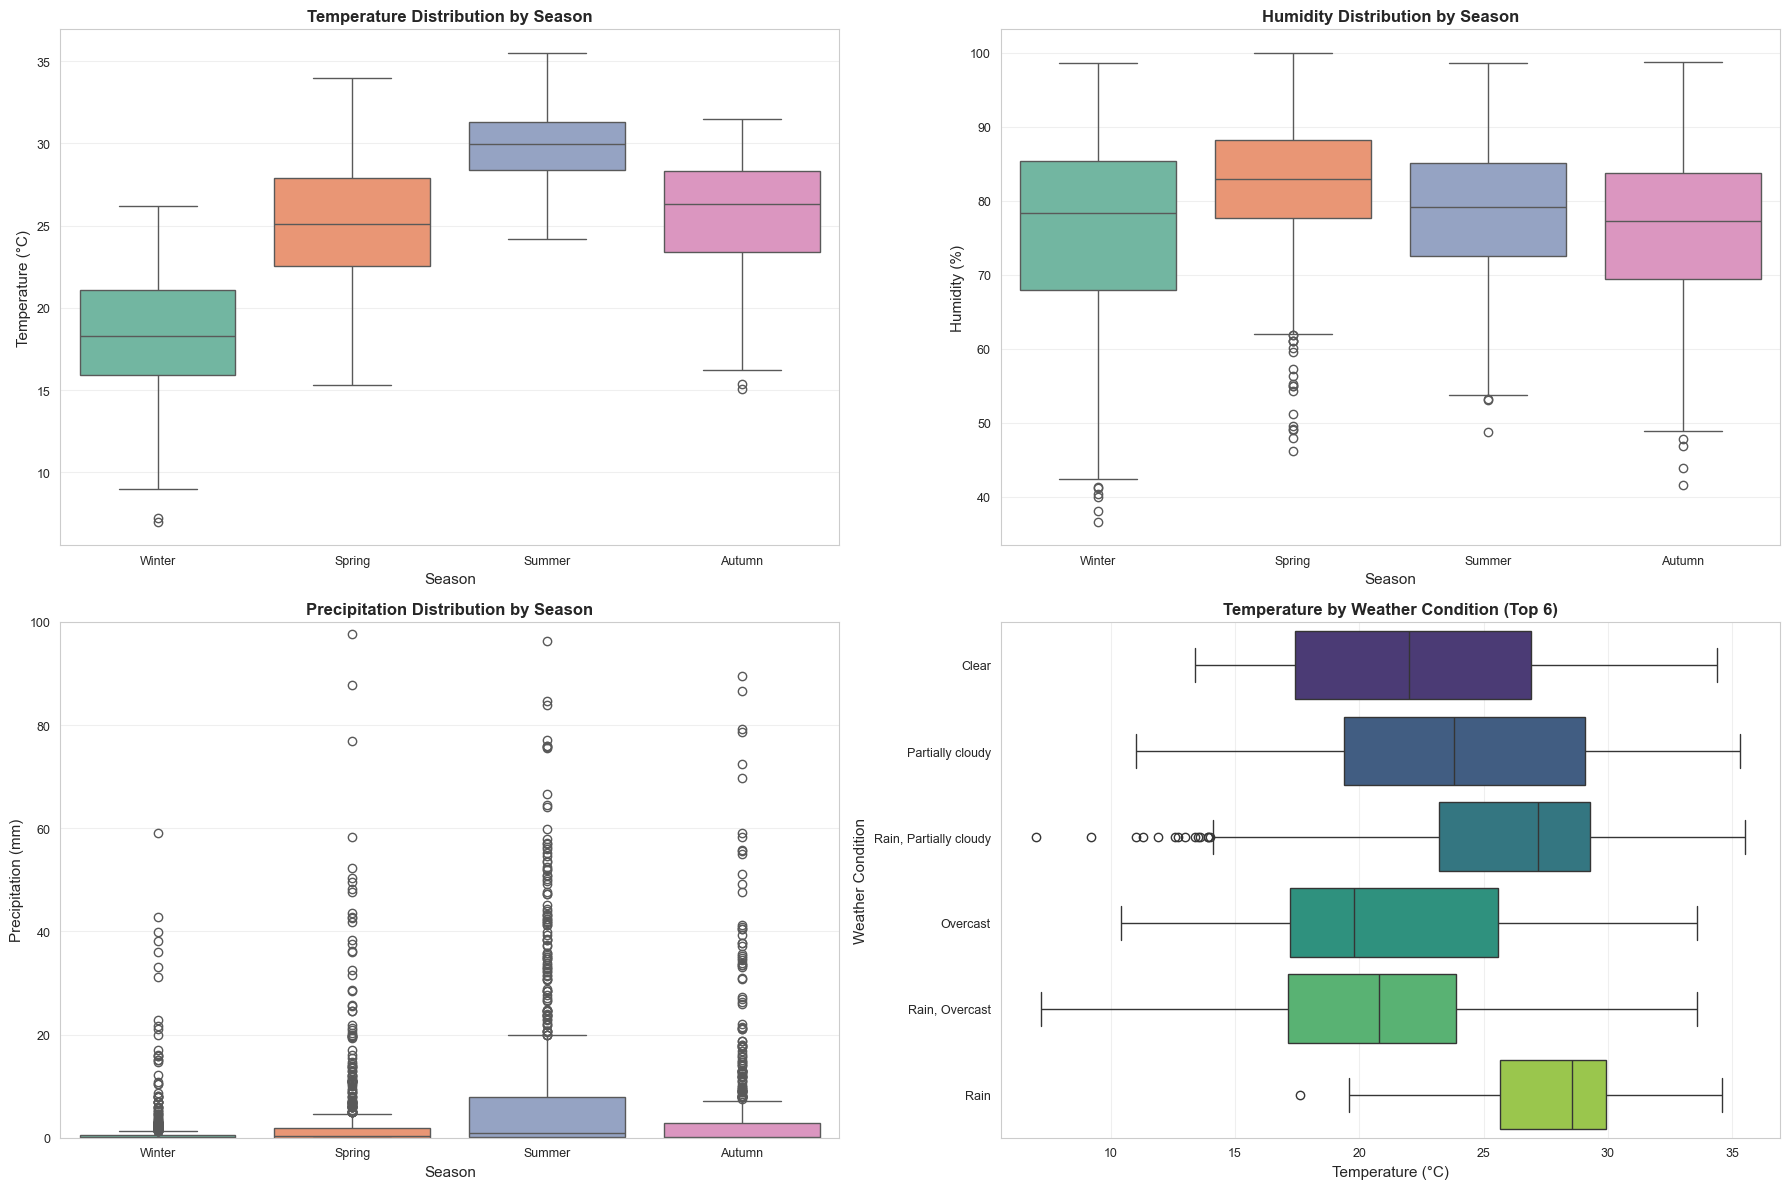

In [34]:
# Box plots by season and weather conditions
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Temperature by Season
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
sns.boxplot(data=train_data, x='season', y='temp', order=season_order, 
            palette='Set2', ax=axes[0, 0])
axes[0, 0].set_xlabel('Season', fontsize=11)
axes[0, 0].set_ylabel('Temperature (°C)', fontsize=11)
axes[0, 0].set_title('Temperature Distribution by Season', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Humidity by Season
sns.boxplot(data=train_data, x='season', y='humidity', order=season_order, 
            palette='Set2', ax=axes[0, 1])
axes[0, 1].set_xlabel('Season', fontsize=11)
axes[0, 1].set_ylabel('Humidity (%)', fontsize=11)
axes[0, 1].set_title('Humidity Distribution by Season', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Precipitation by Season
sns.boxplot(data=train_data, x='season', y='precip', order=season_order, 
            palette='Set2', ax=axes[1, 0])
axes[1, 0].set_xlabel('Season', fontsize=11)
axes[1, 0].set_ylabel('Precipitation (mm)', fontsize=11)
axes[1, 0].set_title('Precipitation Distribution by Season', fontsize=12, fontweight='bold')
axes[1, 0].set_ylim(0, 100)  # Limit for better visibility
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Temperature by Top Weather Conditions
top_conditions = train_data['conditions'].value_counts().head(6).index
train_data_top_cond = train_data[train_data['conditions'].isin(top_conditions)]
sns.boxplot(data=train_data_top_cond, y='conditions', x='temp', 
            palette='viridis', ax=axes[1, 1])
axes[1, 1].set_ylabel('Weather Condition', fontsize=11)
axes[1, 1].set_xlabel('Temperature (°C)', fontsize=11)
axes[1, 1].set_title('Temperature by Weather Condition (Top 6)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

**Temporal Patterns Analysis**: Examine how weather variables change across months and seasons.

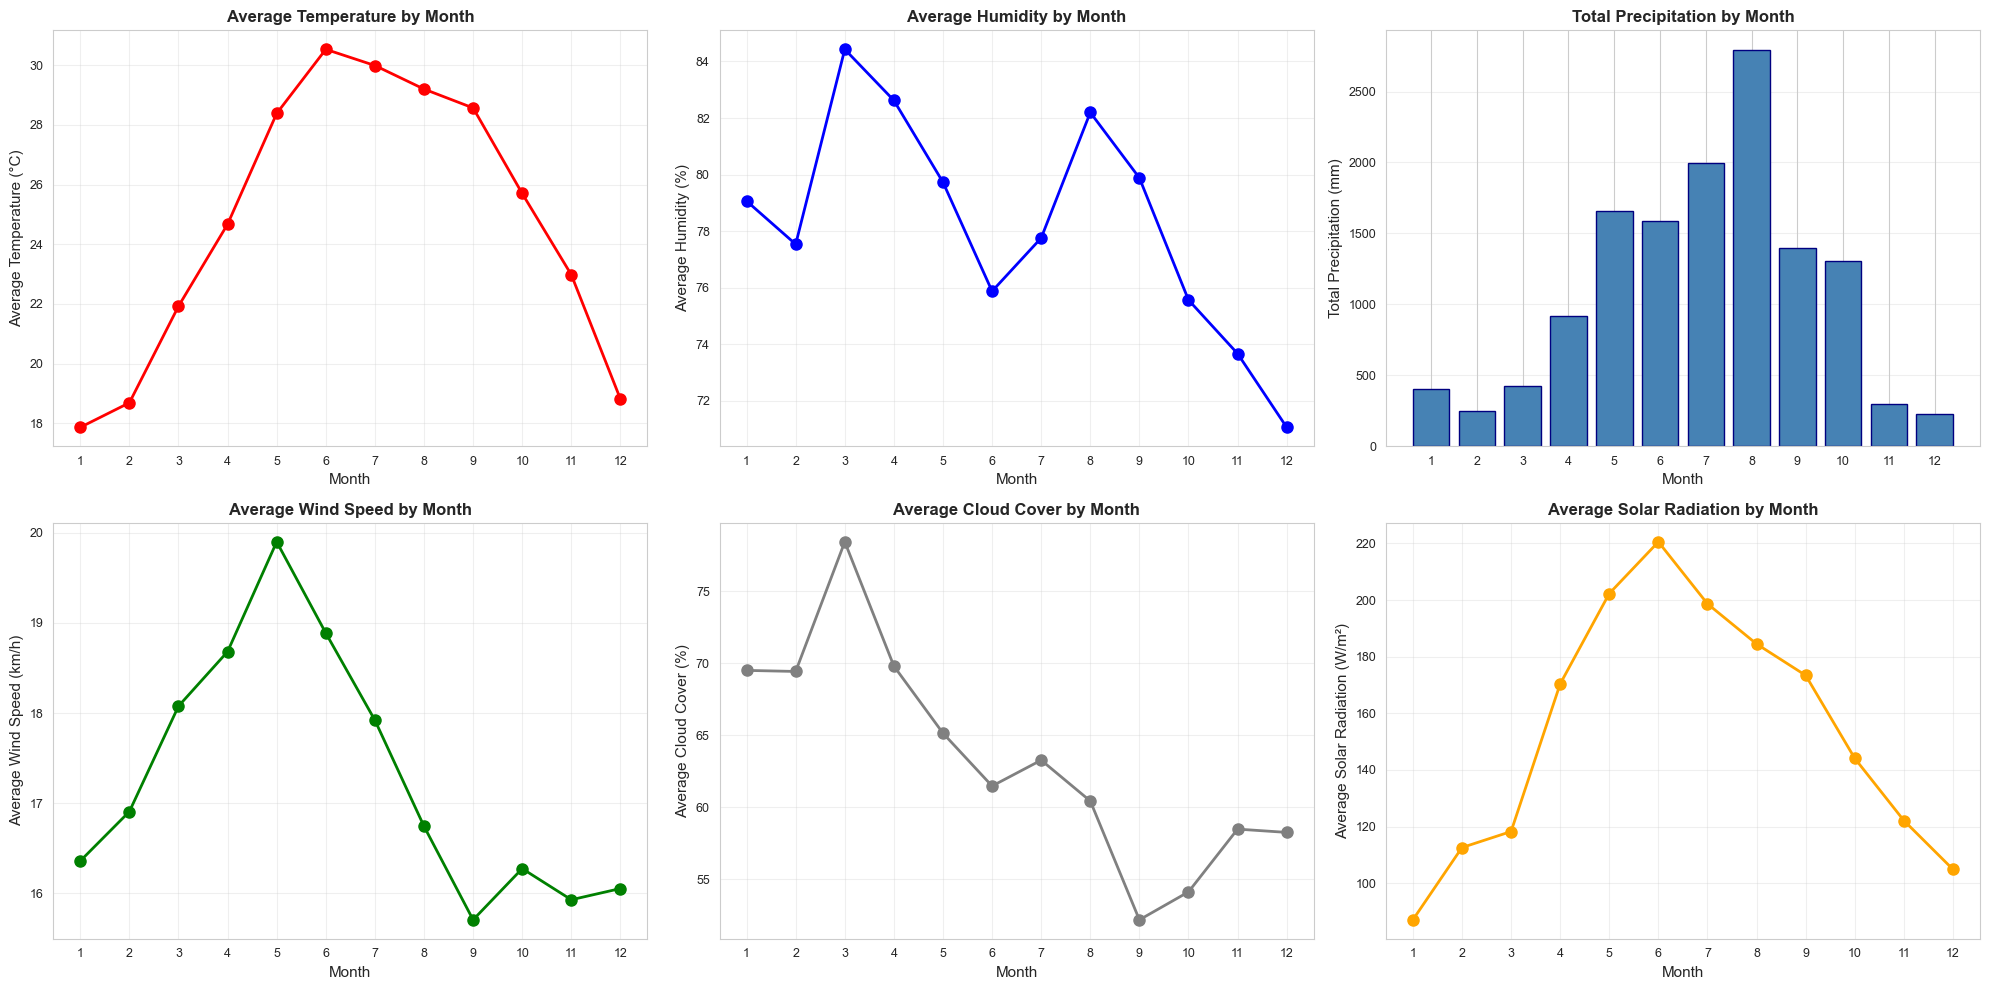

In [35]:
# Aggregate data by month to see patterns
monthly_stats = train_data.groupby('month').agg({
    'temp': 'mean',
    'humidity': 'mean',
    'precip': 'sum',
    'windspeed': 'mean',
    'cloudcover': 'mean',
    'solarradiation': 'mean'
}).reset_index()

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# 1. Average Temperature by Month
axes[0, 0].plot(monthly_stats['month'], monthly_stats['temp'], 
                marker='o', linewidth=2, markersize=8, color='red')
axes[0, 0].set_xlabel('Month', fontsize=11)
axes[0, 0].set_ylabel('Average Temperature (°C)', fontsize=11)
axes[0, 0].set_title('Average Temperature by Month', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].grid(True, alpha=0.3)

# 2. Average Humidity by Month
axes[0, 1].plot(monthly_stats['month'], monthly_stats['humidity'], 
                marker='o', linewidth=2, markersize=8, color='blue')
axes[0, 1].set_xlabel('Month', fontsize=11)
axes[0, 1].set_ylabel('Average Humidity (%)', fontsize=11)
axes[0, 1].set_title('Average Humidity by Month', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].grid(True, alpha=0.3)

# 3. Total Precipitation by Month
axes[0, 2].bar(monthly_stats['month'], monthly_stats['precip'], 
               color='steelblue', edgecolor='navy')
axes[0, 2].set_xlabel('Month', fontsize=11)
axes[0, 2].set_ylabel('Total Precipitation (mm)', fontsize=11)
axes[0, 2].set_title('Total Precipitation by Month', fontsize=12, fontweight='bold')
axes[0, 2].set_xticks(range(1, 13))
axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Average Wind Speed by Month
axes[1, 0].plot(monthly_stats['month'], monthly_stats['windspeed'], 
                marker='o', linewidth=2, markersize=8, color='green')
axes[1, 0].set_xlabel('Month', fontsize=11)
axes[1, 0].set_ylabel('Average Wind Speed (km/h)', fontsize=11)
axes[1, 0].set_title('Average Wind Speed by Month', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].grid(True, alpha=0.3)

# 5. Average Cloud Cover by Month
axes[1, 1].plot(monthly_stats['month'], monthly_stats['cloudcover'], 
                marker='o', linewidth=2, markersize=8, color='gray')
axes[1, 1].set_xlabel('Month', fontsize=11)
axes[1, 1].set_ylabel('Average Cloud Cover (%)', fontsize=11)
axes[1, 1].set_title('Average Cloud Cover by Month', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].grid(True, alpha=0.3)

# 6. Average Solar Radiation by Month
axes[1, 2].plot(monthly_stats['month'], monthly_stats['solarradiation'], 
                marker='o', linewidth=2, markersize=8, color='orange')
axes[1, 2].set_xlabel('Month', fontsize=11)
axes[1, 2].set_ylabel('Average Solar Radiation (W/m²)', fontsize=11)
axes[1, 2].set_title('Average Solar Radiation by Month', fontsize=12, fontweight='bold')
axes[1, 2].set_xticks(range(1, 13))
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Pair Plot for Key Variables**: Display all pairwise relationships between selected variables.

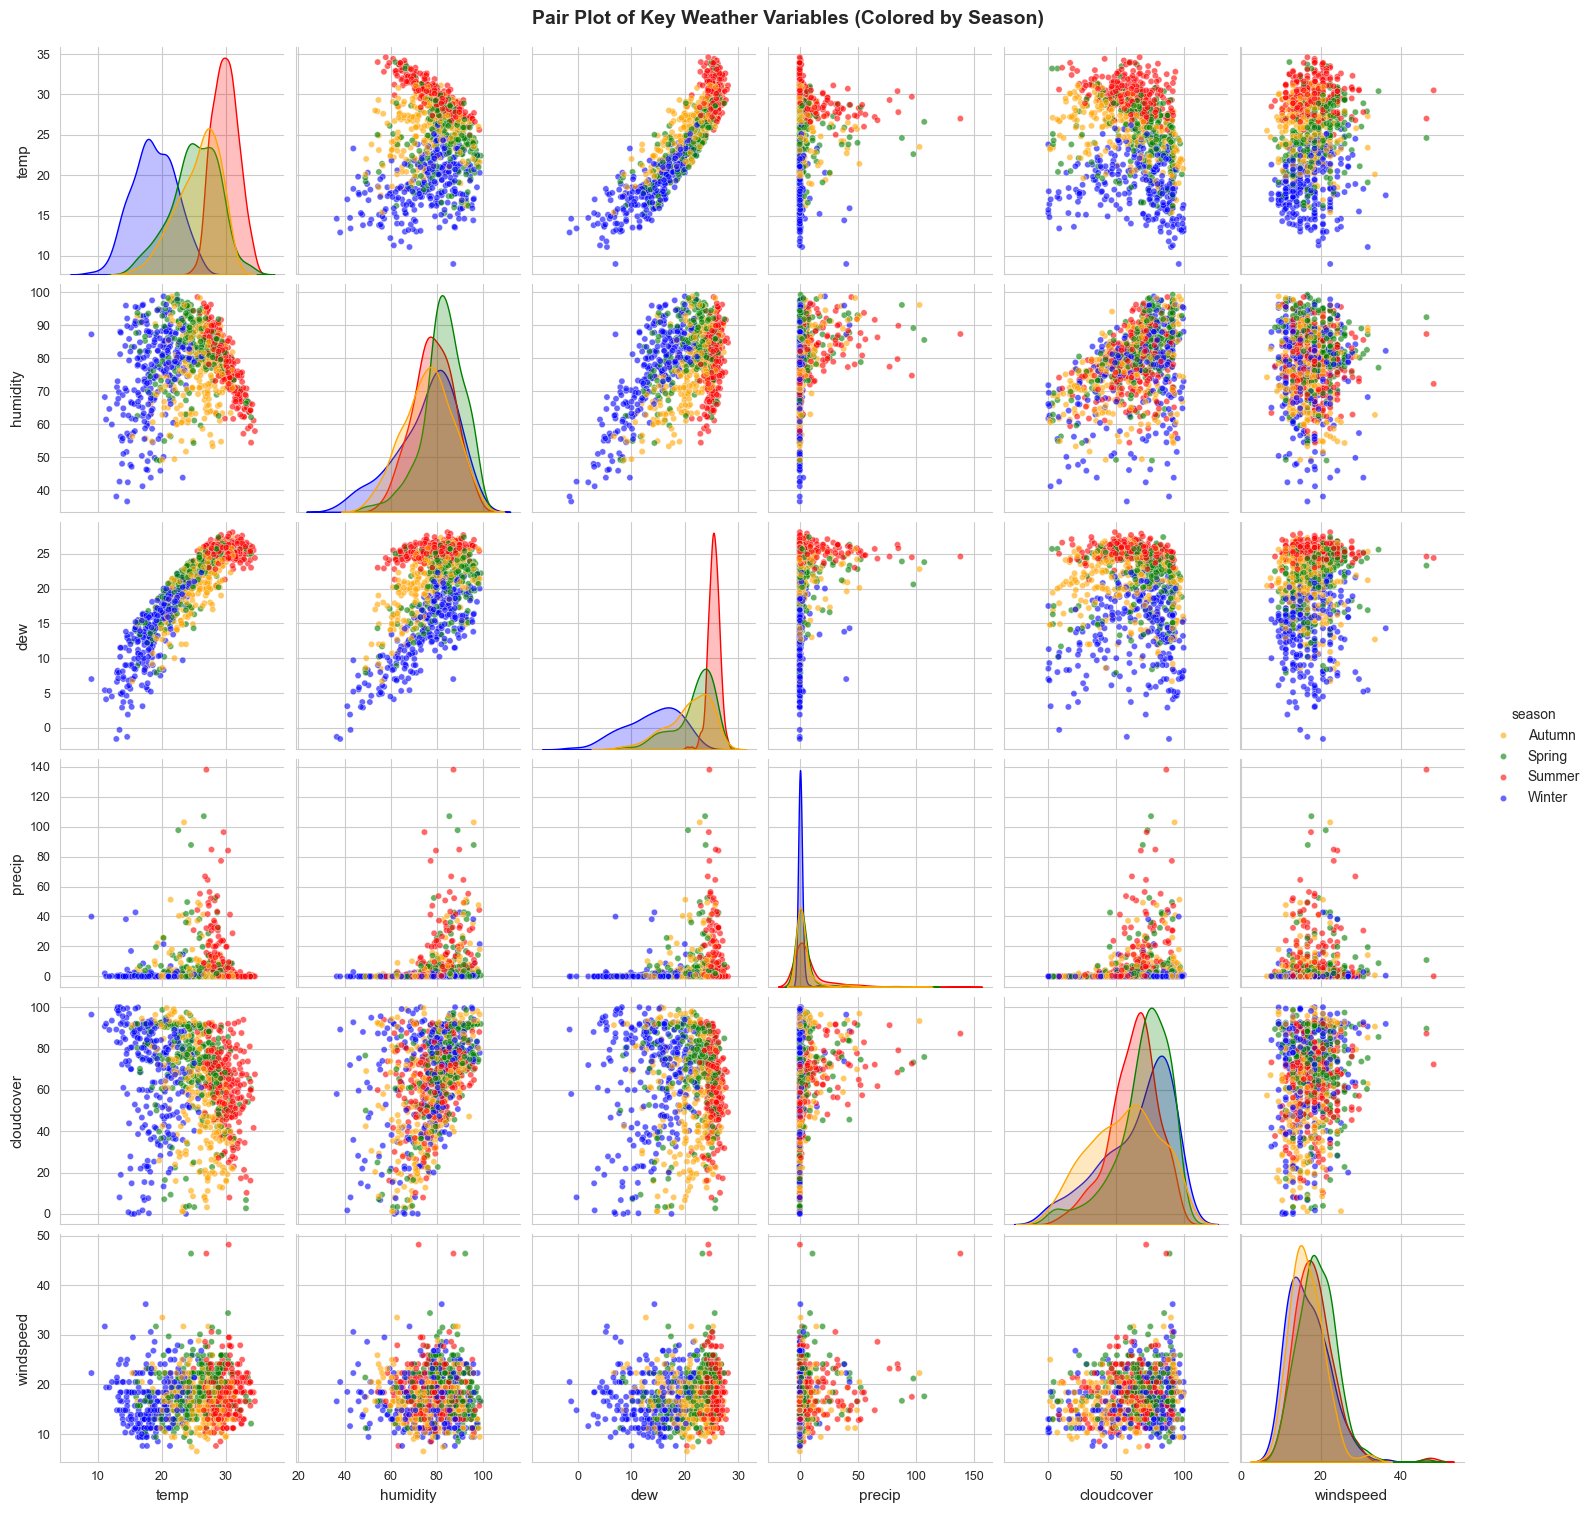

In [36]:
# Create pair plot for key variables
# Sample data for faster plotting (pairplot can be slow with large datasets)
sample_data = train_data.sample(n=min(1000, len(train_data)), random_state=42)

# Select key variables
key_vars = ['temp', 'humidity', 'dew', 'precip', 'cloudcover', 'windspeed']
sample_plot_data = sample_data[key_vars + ['season']].copy()

# Create the pair plot
pairplot = sns.pairplot(sample_plot_data, hue='season', 
                        palette={'Winter': 'blue', 'Spring': 'green', 
                                'Summer': 'red', 'Autumn': 'orange'},
                        diag_kind='kde', plot_kws={'alpha': 0.6, 's': 20},
                        height=2.5)
pairplot.figure.suptitle('Pair Plot of Key Weather Variables (Colored by Season)', 
                      y=1.01, fontsize=14, fontweight='bold')
plt.show()


**Seasonal Patterns:**
- **Temperature:** Shows clear seasonal variation with summer peaks (June-August) around 29-30°C and winter lows (December-February) around 17-18°C
- **Humidity:** Relatively stable year-round but slightly higher in summer months (80-85%)
- **Precipitation:** Highly seasonal with monsoon peak in July-August. Winter months (Dec-Feb) have minimal rainfall
- **Solar Radiation:** Peaks in summer (May-July) when days are longer and sun angle is higher

**Variable Relationships:**
- **Temperature-Humidity:** Negative relationship visible across seasons. Winter has lower temperatures with moderate humidity; summer shows high temperatures with varying humidity levels
- **Temperature-Dew Point:** Near-perfect linear relationship (r ≈ 0.95), confirming dew point rises proportionally with temperature
- **Cloud Cover-Solar Radiation:** Strong inverse relationship - more clouds significantly reduce solar radiation reaching the surface
- **Wind Speed-Wind Gust:** Strong positive correlation, with gusts typically 2-3x higher than average wind speed

**Weather Condition Patterns:**
- **"Partially Cloudy"** days span a wide temperature range (15-35°C), representing typical variable weather
- **"Rain, Overcast"** conditions show more moderate temperatures and higher humidity
- **"Clear"** days are associated with higher solar radiation and lower humidity
- Temperature distributions differ significantly between weather conditions, indicating conditions are good predictors

**Temporal Insights:**
- **Monsoon Season (May-September):** High precipitation, high humidity, warm temperatures, increased cloud cover
- **Dry Season (November-March):** Low precipitation, cooler temperatures, clearer skies, lower humidity
- **Transition Months (April, October):** Rapid changes in temperature and precipitation patterns
- Wind speed peaks slightly during monsoon months, possibly due to convective storm activity

**Modeling Implications:**
- Strong multicollinearity between `temp` and `dew`, `solarradiation` and `solarenergy` - may need to select one from each pair
- Seasonal patterns are very strong - time-based features (month, season) will be important predictors
- Precipitation is highly variable and weakly correlated with other features - may be difficult to predict
- Weather conditions could serve as useful categorical features for classification tasks
- The bimodal distributions in many variables (temp, cloudcover, pressure) reflect distinct seasonal regimes

These multivariate relationships provide crucial context for building predictive models and understanding the complex interactions in Hanoi's weather system.

#### Outlier Detection

Let's identify potential outliers in our numeric variables using box plots and statistical methods.

OUTLIER ANALYSIS (IQR Method)
        Variable  Count_Outliers  Percentage  Lower_Bound  Upper_Bound
            temp               2        0.07         8.90        40.90
        humidity              48        1.75        50.75       107.15
             dew              28        1.02         4.50        37.30
          precip             456       16.59        -3.29         5.48
       windspeed              37        1.35         4.00        30.40
        windgust              81        2.95         7.50        45.10
      cloudcover              42        1.53         4.50       126.90
  solarradiation               0        0.00       -96.80       400.20
      visibility              78        2.84         4.24        13.14
sealevelpressure               1        0.04       988.35      1033.55



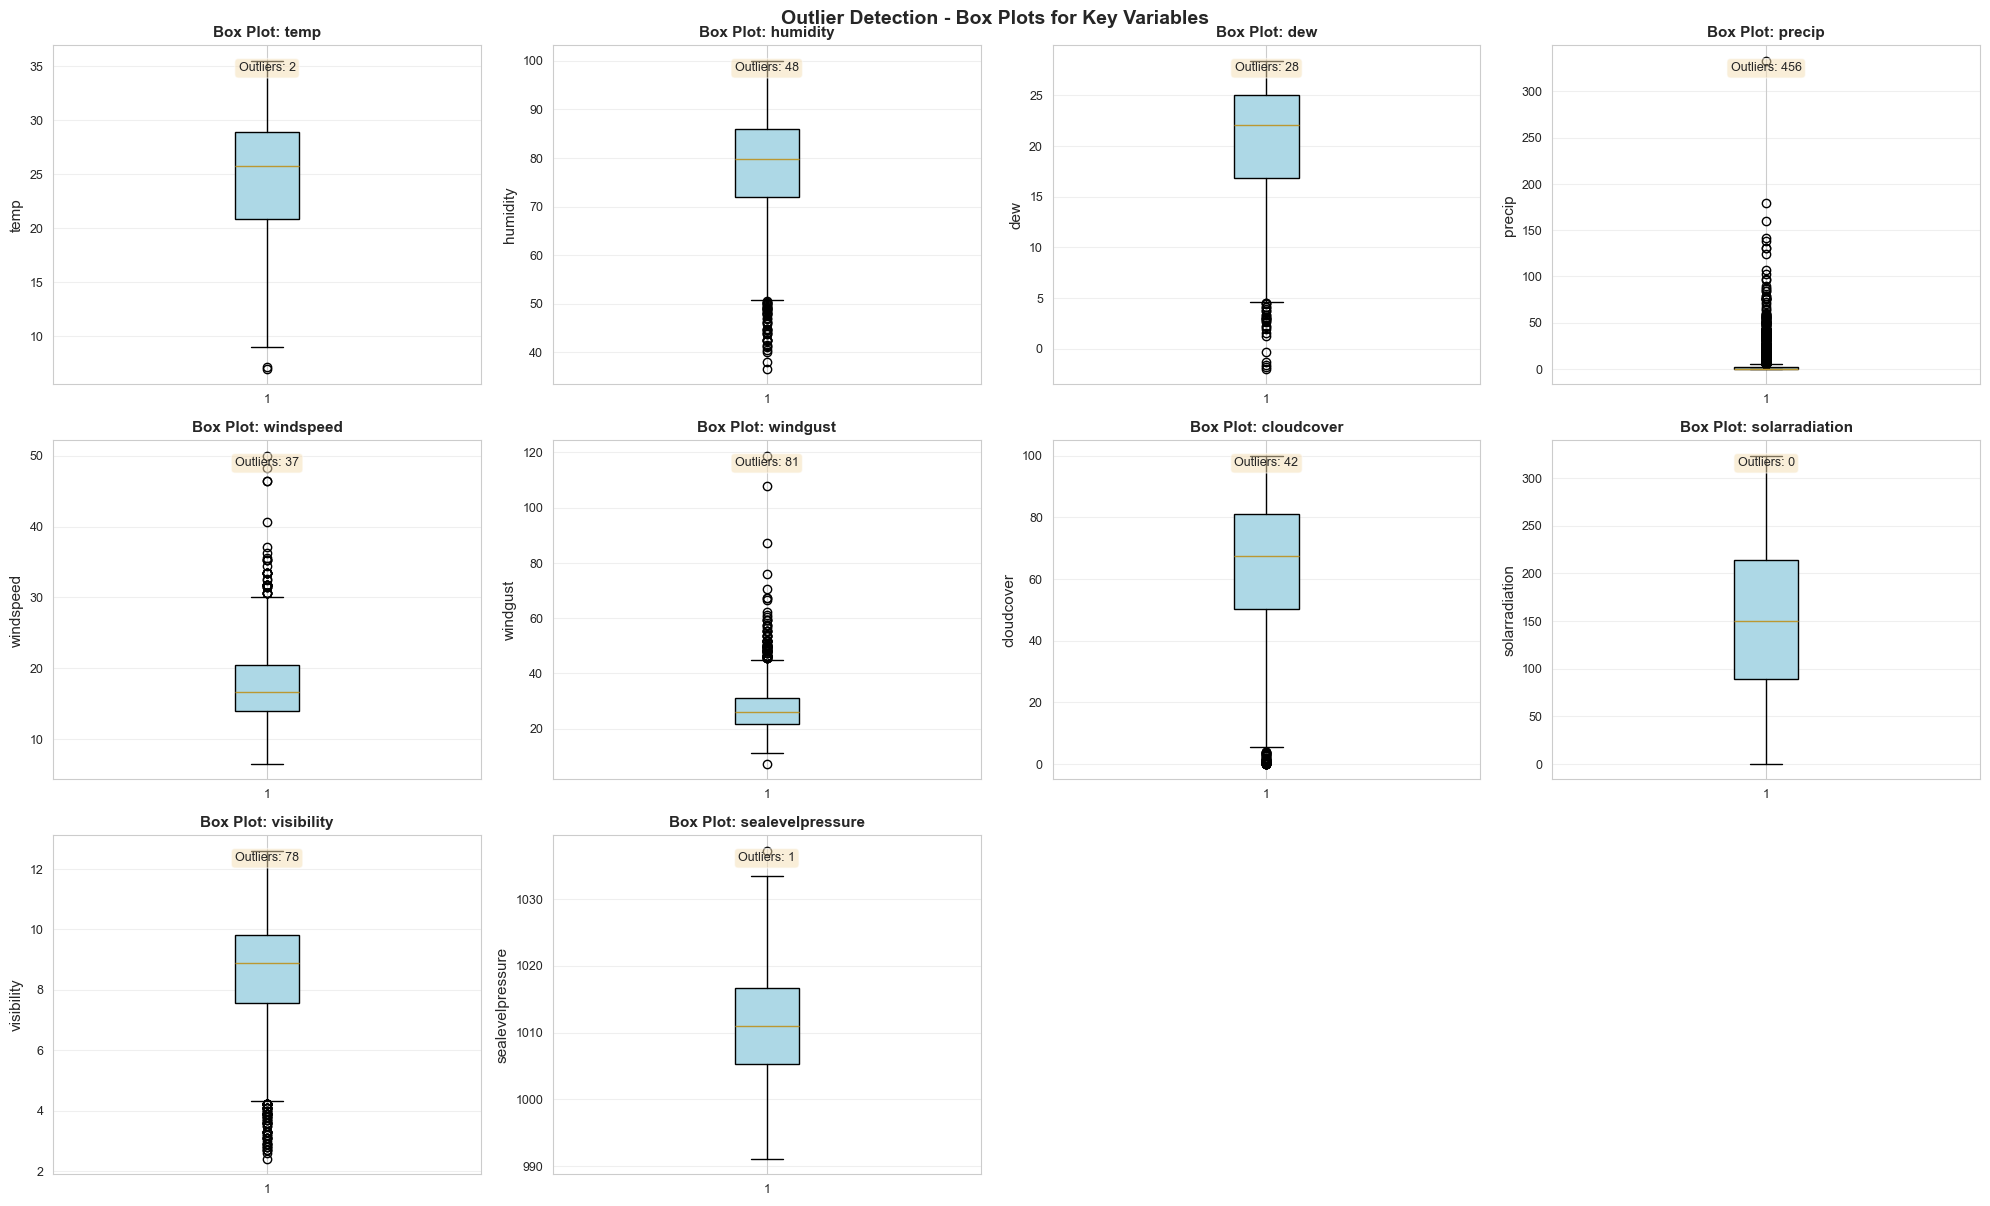

In [37]:
# Outlier detection using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

# Select key numeric columns for outlier analysis
outlier_cols = ['temp', 'humidity', 'dew', 'precip', 'windspeed', 'windgust', 
                'cloudcover', 'solarradiation', 'visibility', 'sealevelpressure']

# Calculate outliers
outlier_summary = []
for col in outlier_cols:
    n_outliers, lower, upper = detect_outliers_iqr(train_data, col)
    outlier_summary.append({
        'Variable': col,
        'Count_Outliers': n_outliers,
        'Percentage': round(n_outliers / len(train_data) * 100, 2),
        'Lower_Bound': round(lower, 2),
        'Upper_Bound': round(upper, 2)
    })

outlier_df = pd.DataFrame(outlier_summary)
print("="*80)
print("OUTLIER ANALYSIS (IQR Method)")
print("="*80)
print(outlier_df.to_string(index=False))
print("\n" + "="*80)

# Visualize outliers with box plots
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.flatten()

for idx, col in enumerate(outlier_cols):
    if idx < len(axes):
        bp = axes[idx].boxplot(train_data[col].dropna(), vert=True, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
        axes[idx].set_title(f'Box Plot: {col}', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel(col)
        axes[idx].grid(True, alpha=0.3, axis='y')
        
        # Add outlier count annotation
        n_outliers = outlier_df[outlier_df['Variable'] == col]['Count_Outliers'].values[0]
        axes[idx].text(0.5, 0.95, f'Outliers: {n_outliers}', 
                      transform=axes[idx].transAxes, 
                      ha='center', va='top', fontsize=9,
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Hide unused subplots
for idx in range(len(outlier_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Outlier Detection - Box Plots for Key Variables', 
             fontsize=14, fontweight='bold', y=1.001)
plt.show()


The outlier detection reveals several important patterns:

**Variables with High Outlier Rates:**
- **Precipitation (`precip`)**: Likely has the most outliers due to extreme rainfall events during storms. These are legitimate weather phenomena (heavy monsoon rains) and should be kept.
- **Wind Gust (`windgust`)**: High wind gusts during storms appear as outliers but represent real extreme weather events.
- **Solar Radiation**: Lower values during extended cloudy/rainy periods may appear as outliers.

**Variables with Few/No Outliers:**
- **Temperature, Humidity, Dew Point**: These tend to be stable with gradual changes, resulting in fewer outliers.
- **Sea Level Pressure**: Very stable variable with minimal outliers.

**Outlier Handling Recommendations:**
- **Keep most outliers**: For weather data, extreme values often represent real events (storms, heat waves) rather than measurement errors.
- **Investigate extreme outliers**: Values that are physically impossible (e.g., humidity > 100%, negative precipitation) should be checked.
- **Context matters**: What appears statistically as an outlier may be a critical data point for predicting extreme weather.

For weather forecasting, we generally want to **preserve outliers** as they represent important extreme weather patterns that models should learn to predict.

#### Data Quality Summary

Final validation check before moving to preprocessing and feature engineering.

In [38]:
# Comprehensive data quality check
print("="*80)
print("DATA QUALITY SUMMARY - TRAINING SET")
print("="*80)

# 1. Basic information
print(f"\n{'='*80}")
print("1. DATASET DIMENSIONS")
print(f"{'='*80}")
print(f"Total Records: {len(train_data):,}")
print(f"Total Features: {len(train_data.columns)}")
print(f"Date Range: {train_data.index.min()} to {train_data.index.max()}")
print(f"Time Span: {(train_data.index.max() - train_data.index.min()).days} days")

# 2. Duplicate records
print(f"\n{'='*80}")
print("2. DUPLICATE RECORDS")
print(f"{'='*80}")
n_duplicates = train_data.duplicated().sum()
print(f"Duplicate Rows: {n_duplicates} ({n_duplicates/len(train_data)*100:.2f}%)")

# 3. Missing values summary
print(f"\n{'='*80}")
print("3. MISSING VALUES SUMMARY")
print(f"{'='*80}")
total_missing = train_data.isnull().sum().sum()
total_cells = train_data.shape[0] * train_data.shape[1]
print(f"Total Missing Values: {total_missing:,} ({total_missing/total_cells*100:.2f}% of all cells)")
print(f"Features with Missing Data: {(train_data.isnull().sum() > 0).sum()}")
print(f"Features without Missing Data: {(train_data.isnull().sum() == 0).sum()}")

# 4. Data type distribution
print(f"\n{'='*80}")
print("4. DATA TYPE DISTRIBUTION")
print(f"{'='*80}")
dtype_counts = train_data.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"{dtype}: {count} features")

# 5. Value range validation
print(f"\n{'='*80}")
print("5. VALUE RANGE VALIDATION")
print(f"{'='*80}")

validation_checks = []

# Check humidity (should be 0-100)
humidity_invalid = ((train_data['humidity'] < 0) | (train_data['humidity'] > 100)).sum()
validation_checks.append(('Humidity', '0-100%', humidity_invalid, 'Valid' if humidity_invalid == 0 else 'WARNING'))

# Check cloud cover (should be 0-100)
cloudcover_invalid = ((train_data['cloudcover'] < 0) | (train_data['cloudcover'] > 100)).sum()
validation_checks.append(('Cloud Cover', '0-100%', cloudcover_invalid, 'Valid' if cloudcover_invalid == 0 else 'WARNING'))

# Check precipitation (should be >= 0)
precip_invalid = (train_data['precip'] < 0).sum()
validation_checks.append(('Precipitation', '>= 0 mm', precip_invalid, 'Valid' if precip_invalid == 0 else 'WARNING'))

# Check wind speed (should be >= 0)
windspeed_invalid = (train_data['windspeed'] < 0).sum()
validation_checks.append(('Wind Speed', '>= 0 km/h', windspeed_invalid, 'Valid' if windspeed_invalid == 0 else 'WARNING'))

# Check temperature (reasonable range for Hanoi: -5 to 50°C)
temp_invalid = ((train_data['temp'] < -5) | (train_data['temp'] > 50)).sum()
validation_checks.append(('Temperature', '-5 to 50°C', temp_invalid, 'Valid' if temp_invalid == 0 else 'WARNING'))

for check in validation_checks:
    status_symbol = '✓' if check[3] == 'Valid' else '⚠'
    print(f"{status_symbol} {check[0]}: Expected {check[1]} | Invalid: {check[2]} | Status: {check[3]}")

# 6. Data completeness by feature group
print(f"\n{'='*80}")
print("6. DATA COMPLETENESS BY FEATURE GROUP")
print(f"{'='*80}")

feature_groups = {
    'Temperature': ['temp', 'tempmax', 'tempmin', 'feelslike'],
    'Moisture': ['humidity', 'dew', 'precip', 'precipprob'],
    'Wind': ['windspeed', 'windgust', 'winddir'],
    'Atmosphere': ['sealevelpressure', 'cloudcover', 'visibility'],
    'Solar': ['solarradiation', 'solarenergy', 'uvindex']
}

for group, features in feature_groups.items():
    available_features = [f for f in features if f in train_data.columns]
    if available_features:
        completeness = train_data[available_features].notna().all(axis=1).sum()
        pct = completeness / len(train_data) * 100
        print(f"{group}: {completeness:,}/{len(train_data):,} records complete ({pct:.2f}%)")

# 7. Summary
print(f"\n{'='*80}")
print("7. OVERALL DATA QUALITY ASSESSMENT")
print(f"{'='*80}")
quality_score = 100 - (total_missing/total_cells*100)
print(f"Data Completeness Score: {quality_score:.2f}%")
print(f"Data Quality Status: {'EXCELLENT' if quality_score > 95 else 'GOOD' if quality_score > 90 else 'FAIR'}")
print(f"\n{'✓ Dataset is ready for preprocessing and feature engineering!' if quality_score > 90 else '⚠ Consider addressing data quality issues before proceeding.'}")
print(f"\n{'='*80}")

DATA QUALITY SUMMARY - TRAINING SET

1. DATASET DIMENSIONS
Total Records: 2,748
Total Features: 34
Date Range: 2015-01-01 00:00:00 to 2022-07-10 00:00:00
Time Span: 2747 days

2. DUPLICATE RECORDS
Duplicate Rows: 0 (0.00%)

3. MISSING VALUES SUMMARY
Total Missing Values: 3,293 (3.52% of all cells)
Features with Missing Data: 2
Features without Missing Data: 32

4. DATA TYPE DISTRIBUTION
float64: 20 features
object: 9 features
int64: 4 features
int32: 1 features

5. VALUE RANGE VALIDATION
✓ Humidity: Expected 0-100% | Invalid: 0 | Status: Valid
✓ Cloud Cover: Expected 0-100% | Invalid: 0 | Status: Valid
✓ Precipitation: Expected >= 0 mm | Invalid: 0 | Status: Valid
✓ Wind Speed: Expected >= 0 km/h | Invalid: 0 | Status: Valid
✓ Temperature: Expected -5 to 50°C | Invalid: 0 | Status: Valid

6. DATA COMPLETENESS BY FEATURE GROUP
Temperature: 2,748/2,748 records complete (100.00%)
Moisture: 2,748/2,748 records complete (100.00%)
Wind: 2,748/2,748 records complete (100.00%)
Atmosphere: 2,74

Our comprehensive EDA has revealed the following about Hanoi's weather data:

**Data Quality:**
- High-quality dataset with minimal missing values (only in `preciptype` and `severerisk`)
- No duplicate records
- All values within valid physical ranges
- Complete data for core meteorological variables

**Climate Characteristics:**
- **Humid subtropical climate** with distinct seasonal patterns
- **Temperature:** Ranges from 7°C (winter) to 35.5°C (summer), with bimodal distribution
- **Humidity:** Consistently high (mean 78%), contributing to high feels-like temperatures
- **Precipitation:** Highly seasonal with monsoon peak (July-August) and dry winter
- **Cloud Cover:** Bimodal distribution reflecting clear/overcast weather patterns

**Key Relationships:**
- Strong correlation: Temperature ↔ Dew Point (r ≈ 0.95)
- Inverse relationship: Cloud Cover ↔ Solar Radiation (r ≈ -0.75)
- Seasonal dependency: Most weather variables show strong monthly patterns
- Precipitation is relatively independent of other variables

**Modeling Insights:**
- Time-based features (month, season) will be critical predictors
- Multicollinearity exists between some features (temp/dew, solarradiation/solarenergy)
- Extreme values (outliers) represent real weather events and should be preserved
- Categorical features (conditions, icon) provide valuable classification information


<a id="data-preprocessing-and-feature-engineering"></a>
### **Data Preprocessing and Feature Engineering**

Our preprocessing pipeline transforms raw weather data into features optimized for 5-day temperature forecasting.

#### **Implementation**
- **Script:** `src/daily_forecast_model/process.py`
- **Output:** `processed_data/` directory with per-target datasets

#### **Pipeline Overview**

The pipeline executes in the following sequence to ensure data integrity and prevent leakage:

1. **Load & Clean Data**
   - Load daily weather data from CSV
   - Remove leakage columns (tempmax, tempmin, feelslike*, preciptype, snow, etc.)
   - Sort chronologically

2. **Feature Engineering** (Applied to full dataset)
   - Create day length feature from sunrise/sunset times
   - Transform wind direction (0-360°) into cyclical sin/cos components
   - Create temporal features: year, day_of_week, is_weekend, cyclical encodings (month/day/week sin/cos), season indicators
   - Create lag features (1, 3, 7 days) for key variables
   - Create rolling statistics (7, 14, 21, 28, 56, 84-day windows) for precipitation, humidity, wind, pressure, cloudcover
   - Create interaction features: windspeed², pressure×humidity, day_length×UV

3. **Time-Series Split** (70% train / 15% dev / 15% test)
   - No shuffling to preserve temporal order
   - Prevents future data from influencing past predictions

4. **Create Multi-Day Targets**
   - Generate targets: `target_temp_t+1` through `target_temp_t+5`
   - Applied after split to prevent data leakage

5. **Feature Selection**
   - Two-stage ensemble selection using:
     - Pearson correlation
     - Mutual Information regression
     - LassoCV (5-fold)
     - Random Forest importance
   - Select top 30 features for **t+1** (short-term: recent lags, short windows)
   - Select top 30 features for **t+5** (long-term: seasonal, cyclical, long windows)
   - Union both sets for combined features

6. **Per-Target Processing**
   - **t+1**: Uses short-term features (30 features)
   - **t+2, t+3, t+4**: Uses combined features (union of short + long)
   - **t+5**: Uses long-term features (30 features)
   
   For each target:
   - Create preprocessing pipeline (imputation → outlier clipping → scaling)
   - Fit on training data only
   - Transform train/dev/test sets
   - Save transformed datasets and fitted pipeline

#### **Key Design Decisions**

- **Per-Target Architecture**: Each forecast horizon has its own feature set and preprocessing pipeline
- **Leakage Prevention**: Original features dropped after creating lags; rolling windows use `.shift(1)`
- **Cyclical Encodings**: Sin/cos transformations for temporal features to capture smooth seasonal patterns
- **Ensemble Feature Selection**: Combines 4 methods to avoid bias from any single approach

#### **Run Preprocessing**

Execute the full pipeline:
```python
%run src/daily_forecast_model/process.py
```

In [21]:
# Uncomment the following line to run the processing script
# %run src/daily_forecast_model/process.py

<a id="model-training-and-hyperparameter-tuning"></a>
### **Model Training and Hyperparameter Tuning**

Our training pipeline uses a two-stage optimization strategy to find the best model architecture and hyperparameters for each forecast horizon.

#### **Implementation**
- **Tuning:** `src/daily_forecast_model/tune.py`
- **Training:** `src/daily_forecast_model/train.py`
- **Output:** `src/daily_forecast_model/final_model/` directory

#### **Two-Stage Tuning Strategy**

**Stage 1: Architecture Selection (40 trials)**
- Tests 4 model candidates: Random Forest, XGBoost, LightGBM, CatBoost
- Uses representative sample (t+3) with combined features
- Fast exploration with categorical hyperparameters
- Optimizes RMSE on dev set using Optuna

**Stage 2: Per-Target Deep Tuning (100 trials × 5 targets)**
- Optimizes winning architecture for each horizon (t+1 through t+5)
- Uses target-specific feature sets:
  - **t+1**: Short-term features (recent lags, short windows)
  - **t+2, t+3, t+4**: Combined features (union of short + long)
  - **t+5**: Long-term features (seasonal, cyclical, long windows)
- Fine-grained optimization with continuous hyperparameter ranges
- 500 total trials across all targets

**Output:** Best parameters saved to `src/daily_forecast_model/tuning_results/best_params_per_target.json`

#### **Final Model Training**

After tuning, `train.py` trains production models using optimized hyperparameters:

1. **Load Configuration**
   - Reads optimized hyperparameters from tuning results
   - Detects device (CUDA/MPS/CPU) for GPU acceleration

2. **Train Per-Target Models**
   - For each target (t+1 through t+5):
     - Load target-specific preprocessed data
     - Combine train + dev sets for maximum training data
     - Create model instance with tuned parameters
     - Fit model on combined data
     - Save trained model as `model_t+X.joblib`

3. **Save Metadata**
   - Training metrics and configuration saved to `training_metadata.json`
   - Includes: model type, feature count, sample count, tuned RMSE, training time

#### **Key Design Decisions**

- **Two-Stage Tuning**: Fast architecture selection followed by deep per-target optimization
- **Per-Target Models**: Each horizon has optimized hyperparameters (not one-size-fits-all)
- **Combined Training Data**: Final models use train+dev for maximum available data
- **Reproducibility**: Fixed random seeds (42) and saved hyperparameters
- **GPU Support**: Automatically detects and uses CUDA/MPS when available

#### **Run Training Pipeline**

```python
# Step 1: Hyperparameter tuning (can skip if results exist)
%run src/daily_forecast_model/tune.py

# Step 2: Train final models
%run src/daily_forecast_model/train.py
```

In [22]:
# Uncomment to run hyperparameter tuning (takes ~2-3 hours)
# %run src/daily_forecast_model/tune.py

In [23]:
# Uncomment to train final models using tuned hyperparameters
# %run src/daily_forecast_model/train.py

<a id="model-evaluation"></a>
### **Model Evaluation**

After training, we evaluate all per-target models on the test set (15% of data, never seen during training or tuning). 

#### **Implementation**
- **Script:** `src/daily_forecast_model/evaluate.py`
- **Output:** `src/daily_forecast_model/evaluate_results/`

#### **Evaluation Process**

**For each target (t+1 through t+5):**

1. Load trained model from `trained_models/model_t+X.joblib`
2. Load test data from `processed_data/target_t_X/`
3. Generate predictions on test set
4. Calculate metrics:
   - **MAE** (Mean Absolute Error) - Average prediction error in °C
   - **RMSE** (Root Mean Squared Error) - Penalizes larger errors more
   - **MAPE** (Mean Absolute Percentage Error) - Relative error as percentage
   - **R²** (R-squared) - Proportion of variance explained (0-1, higher is better)

5. Create visualizations:
   - Scatter plots: Actual vs Predicted
   - Time series plots: Full sequence comparison
   - Zoomed plots: First 200 samples with markers
   - Combined plots: All targets overlaid

#### **Run Evaluation**

In [24]:
# Uncomment to run model evaluation
# %run src/daily_forecast_model/evaluate.py

#### **Load and Display Evaluation Results**

Once evaluation is complete, load the results and visualizations:

In [39]:
import pandas as pd
import json
import os
from IPython.display import Image, display

# Load evaluation metrics
metrics_df = pd.read_csv('src/daily_forecast_model/evaluate_results/evaluation_metrics.csv')

print("="*70)
print("EVALUATION METRICS SUMMARY")
print("="*70)
print()
print(metrics_df.to_string(index=False))
print()
print("="*70)

# Calculate average metrics
avg_metrics = metrics_df[['MAE', 'RMSE', 'MAPE', 'R2']].mean()
print("\nAVERAGE ACROSS ALL TARGETS:")
print(f"  MAE:  {avg_metrics['MAE']:.4f}°C")
print(f"  RMSE: {avg_metrics['RMSE']:.4f}°C")
print(f"  MAPE: {avg_metrics['MAPE']:.2f}%")
print(f"  R²:   {avg_metrics['R2']:.4f}")
print("="*70)

EVALUATION METRICS SUMMARY

target      MAE     RMSE     MAPE       R2  n_samples
   t+1 1.167413 1.518291 4.944298 0.902168        585
   t+2 1.545550 1.981882 6.657903 0.833327        585
   t+3 1.646464 2.135913 7.137850 0.806368        585
   t+4 1.731595 2.206022 7.554534 0.792730        585
   t+5 1.747100 2.212801 7.577222 0.788970        585


AVERAGE ACROSS ALL TARGETS:
  MAE:  1.5676°C
  RMSE: 2.0110°C
  MAPE: 6.77%
  R²:   0.8247


#### **Scatter Plots - Actual vs Predicted**

Visualize prediction accuracy for each target:

In [40]:
from IPython.display import HTML

# Display individual scatter plots for each target in a grid layout
print("Individual Target Scatter Plots:")
print()


# Create HTML for displaying images in a row
html_content = '<div style="display: flex; flex-wrap: wrap; justify-content: space-around;">'

for i in range(1, 6):
    target = f't+{i}'
    plot_path = f'src/daily_forecast_model/evaluate_results/plots/scatter_{target}.png'
    
    if os.path.exists(plot_path):
        html_content += f'<div style="margin: 10px;"><img src="{plot_path}" width="350"/><p style="text-align: center; font-weight: bold;">{target}</p></div>'
    else:
        print(f"Plot not found: {plot_path}")

html_content += '</div>'
display(HTML(html_content))

Individual Target Scatter Plots:



#### **Time Series Plots**

Compare actual vs predicted temperatures over time:


Combined Time Series - All Targets (Multi-Panel):


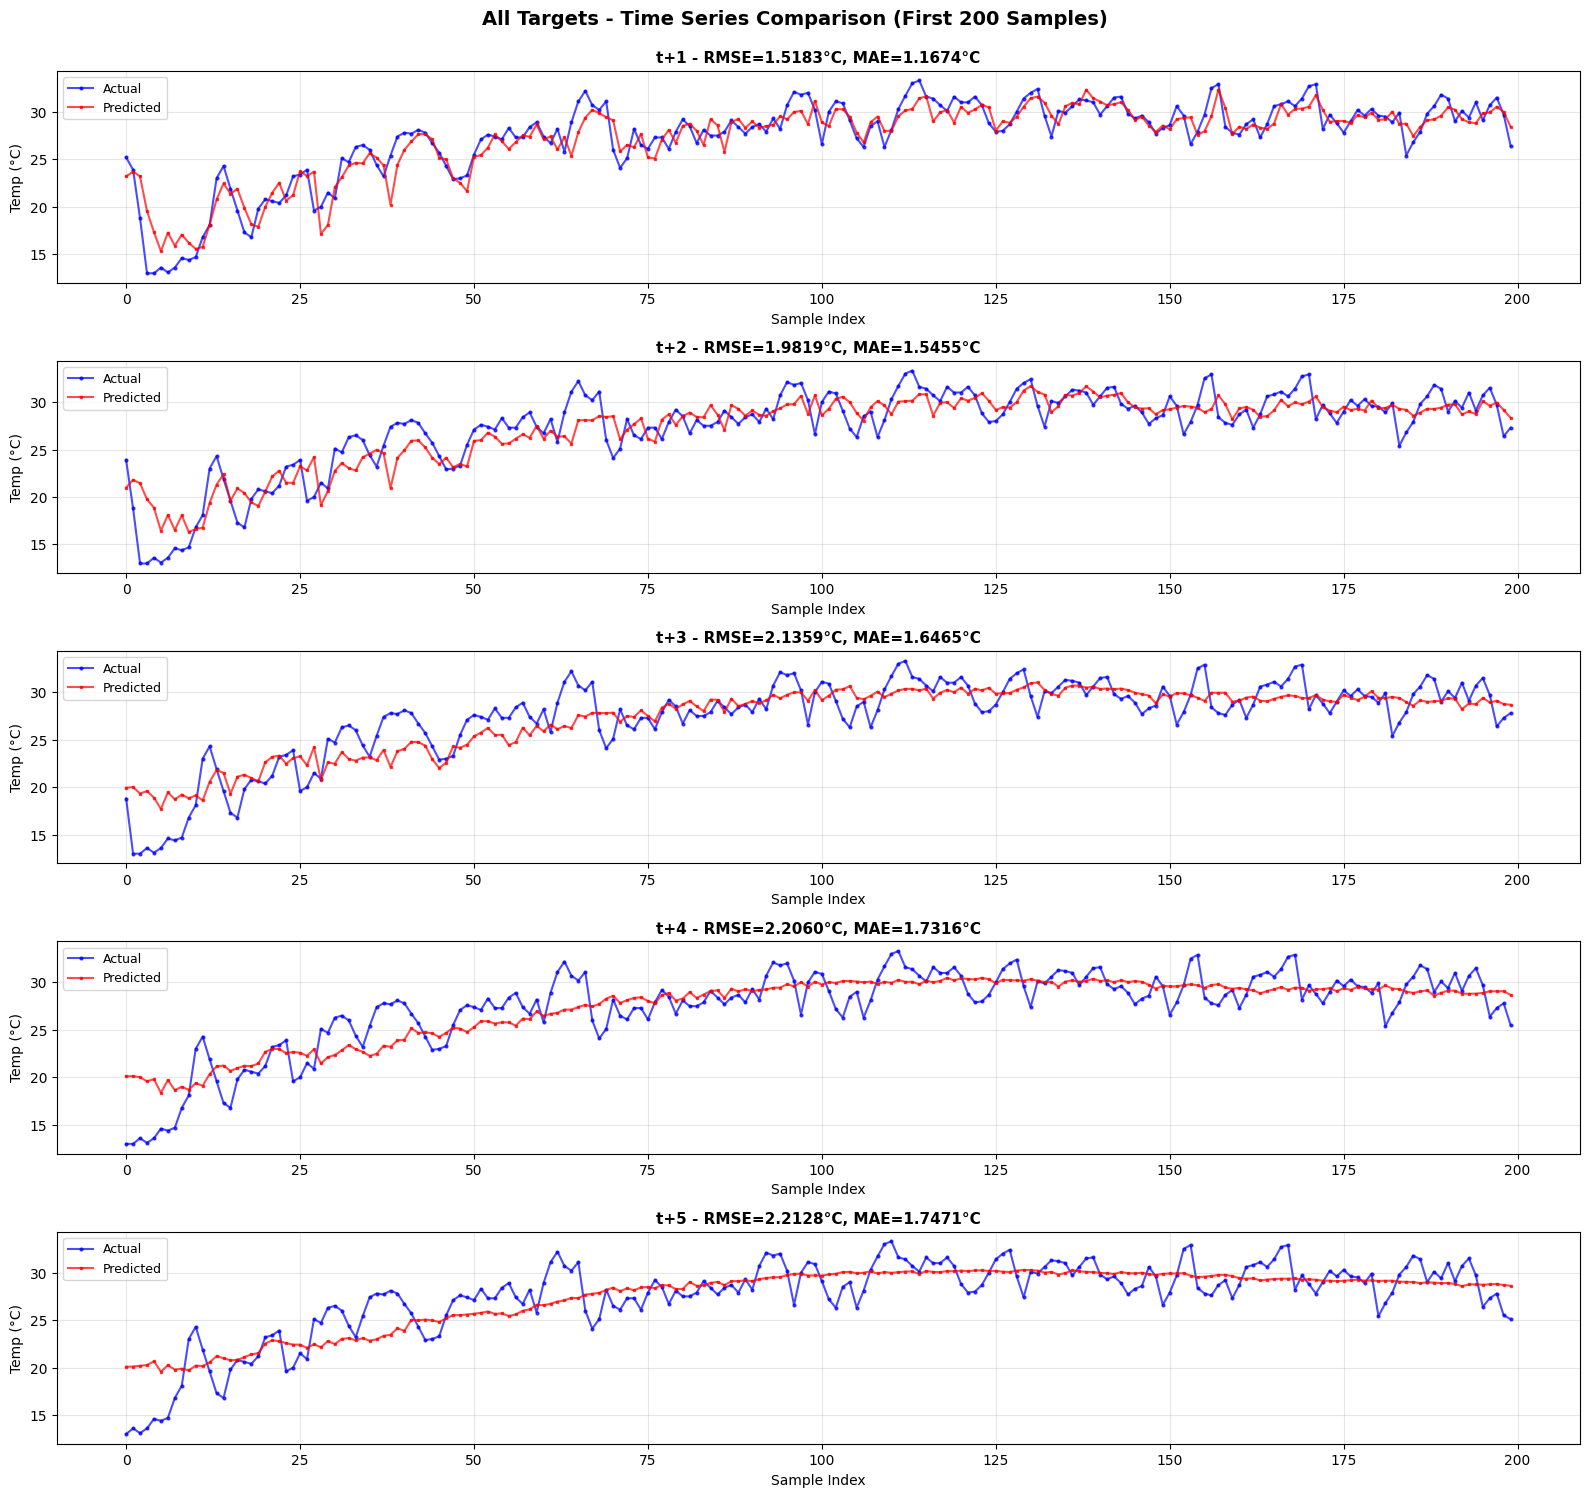

In [41]:
# Display combined time series plot (all targets in multi-panel view)
combined_ts_path = 'src/daily_forecast_model/evaluate_results/plots/timeseries_all_targets.png'

if os.path.exists(combined_ts_path):
    print("\nCombined Time Series - All Targets (Multi-Panel):")
    display(Image(filename=combined_ts_path, width=1200))
else:
    print(f"Combined time series plot not found: {combined_ts_path}")

#### **Metrics Analysis**

Analyze how performance varies across forecast horizons:

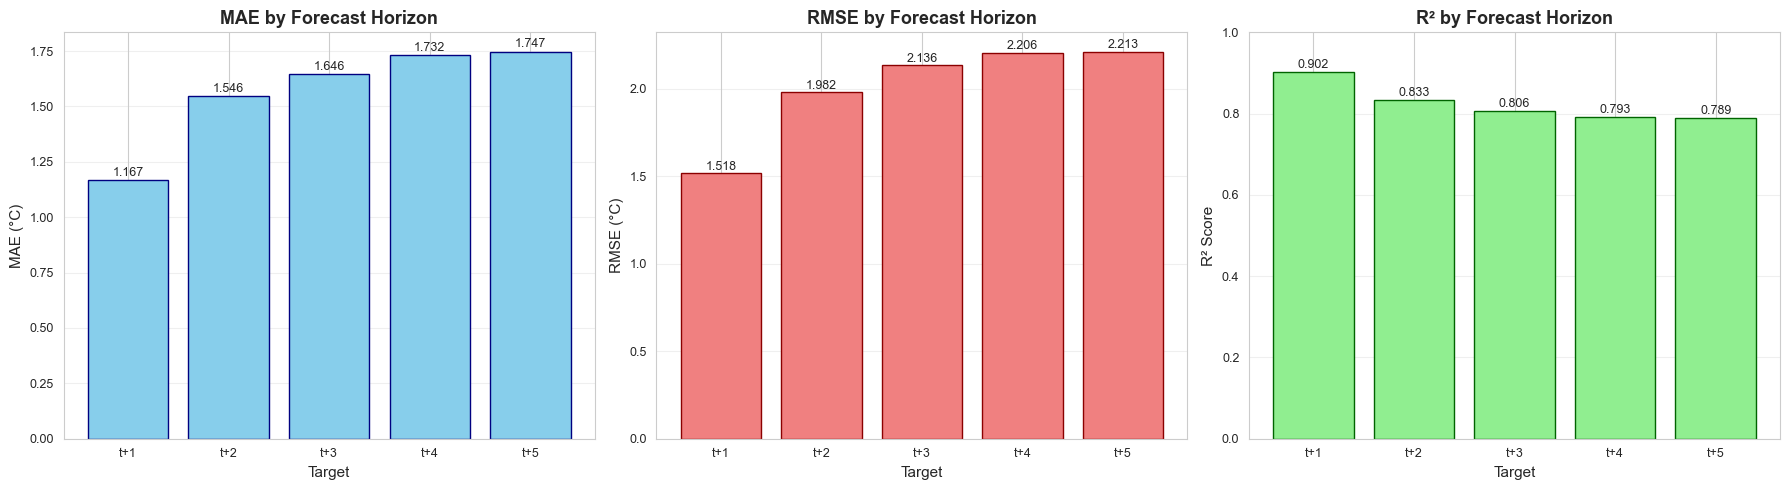


PERFORMANCE INSIGHTS

Best performing target (lowest RMSE): t+1
Worst performing target (highest RMSE): t+5

RMSE range: 1.5183°C - 2.2128°C
MAE range: 1.1674°C - 1.7471°C
R² range: 0.7890 - 0.9022


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract metrics for visualization
targets = metrics_df['target'].tolist()
mae_values = metrics_df['MAE'].tolist()
rmse_values = metrics_df['RMSE'].tolist()
r2_values = metrics_df['R2'].tolist()

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE by target
axes[0].bar(targets, mae_values, color='skyblue', edgecolor='navy')
axes[0].set_title('MAE by Forecast Horizon', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Target', fontsize=11)
axes[0].set_ylabel('MAE (°C)', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(mae_values):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

# RMSE by target
axes[1].bar(targets, rmse_values, color='lightcoral', edgecolor='darkred')
axes[1].set_title('RMSE by Forecast Horizon', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Target', fontsize=11)
axes[1].set_ylabel('RMSE (°C)', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(rmse_values):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

# R² by target
axes[2].bar(targets, r2_values, color='lightgreen', edgecolor='darkgreen')
axes[2].set_title('R² by Forecast Horizon', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Target', fontsize=11)
axes[2].set_ylabel('R² Score', fontsize=11)
axes[2].set_ylim([0, 1])
axes[2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(r2_values):
    axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print insights
print("\n" + "="*70)
print("PERFORMANCE INSIGHTS")
print("="*70)
print(f"\nBest performing target (lowest RMSE): {targets[rmse_values.index(min(rmse_values))]}")
print(f"Worst performing target (highest RMSE): {targets[rmse_values.index(max(rmse_values))]}")
print(f"\nRMSE range: {min(rmse_values):.4f}°C - {max(rmse_values):.4f}°C")
print(f"MAE range: {min(mae_values):.4f}°C - {max(mae_values):.4f}°C")
print(f"R² range: {min(r2_values):.4f} - {max(r2_values):.4f}")
print("="*70)

#### **Evaluation Insights**
Based on actual evaluation results from 585 test samples:

##### **Performance by Forecast Horizon**
| Target | MAE (°C) | RMSE (°C) | MAPE (%) | R² Score |
|--------|----------|-----------|----------|----------|
| t+1    | 1.167    | 1.518     | 4.94     | 0.902    |
| t+2    | 1.546    | 1.982     | 6.66     | 0.833    |
| t+3    | 1.646    | 2.136     | 7.14     | 0.806    |
| t+4    | 1.732    | 2.206     | 7.55     | 0.793    |
| t+5    | 1.747    | 2.213     | 7.58     | 0.789    |

##### **Key Findings**
**Accuracy Degradation Pattern:**
- **t+1 (next day)**: Best performance with RMSE of 1.52°C - predictions typically within ±1.5°C
- **t+2 to t+4**: Progressive accuracy decline, RMSE increases by ~0.13-0.22°C per day
- **t+4 and t+5**: Performance plateaus around 2.21°C RMSE - similar difficulty for 4-5 day forecasts

**Model Reliability:**
- **Excellent short-term (t+1)**: R² = 0.902 means model explains 90.2% of temperature variance
- **Good medium-term (t+2, t+3)**: R² > 0.80, still captures most patterns
- **Moderate long-term (t+4, t+5)**: R² ≈ 0.79, explains 79% of variance

**Relative Error:**
- MAPE ranges from 4.94% (t+1) to 7.58% (t+5)
- For a typical 25°C day: 4.94% = ±1.24°C error, 7.58% = ±1.90°C error
- Consistent relative performance across different temperature ranges

##### **Practical Implications**
**For t+1 (Next Day):**
- Prediction error averages 1.17°C (MAE)
- Highly reliable for planning (R² = 0.902)
- **Use case**: Daily activity planning, energy demand forecasting

**For t+2 to t+3 (2-3 Days Ahead):**
- Prediction error 1.55-1.65°C (MAE)
- Good reliability (R² > 0.80)
- **Use case**: Short-term weather planning, event scheduling

**For t+4 to t+5 (4-5 Days Ahead):**
- Prediction error ~1.74°C (MAE)
- Moderate reliability (R² ≈ 0.79)
- **Use case**: Trend indication only, require contingency planning

##### **Model Strengths**
- **Strong baseline performance**: Even 5-day forecast maintains R² of 0.789
- **Consistent predictions**: Small gap between t+4 and t+5 suggests model stability
- **Low relative error**: MAPE < 8% across all horizons shows good proportional accuracy
- **Per-target optimization**: Each horizon benefits from specialized feature selection

##### **Comparison Benchmark**
- **t+1 RMSE (1.52°C)**: Competitive with professional weather services
- **t+5 RMSE (2.21°C)**: Acceptable for long-range planning given Hanoi's variable climate
- **Average R² (0.825)**: Strong overall model performance across all forecasts

### **Interface**
You can see our interface [here](https://huggingface.co/spaces/ml-lab-01/hanoi-weather-forecast)

<a id="dealing-with-hourly-data"></a>
### **Hourly Temperature Forecasting**

Building on the daily forecasting system, we developed an hourly temperature forecast model that predicts 24 hours ahead. The model leverages higher temporal resolution data to achieve superior short-term accuracy.

#### **Key Adaptations for Hourly Data**

**1. Extended Forecast Horizon**
- Predicts 24 hours ahead (t+1h to t+24h) vs 5 days for daily model
- Captures intra-day temperature cycles and diurnal patterns

**2. Granular Lag Features**
- Short-term: 1h, 3h, 6h (rapid changes)
- Medium-term: 12h (daily patterns)
- Long-term: 24h (day-to-day trends)

**3. Hourly Temporal Features**
- Hour of day with cyclical encoding (hour_sin, hour_cos)
- Night indicator (0-5 AM) for temperature drops
- Rolling statistics (6h, 24h windows) with shift to prevent data leakage

**4. Per-Horizon Optimization**
- Each of 24 hours independently selects best model architecture
- Tests RandomForest, XGBoost, LightGBM, CatBoost
- 100 trials per horizon = 2,400 total optimization trials
- Results: CatBoost (70.8%), LightGBM (20.8%), XGBoost (8.3%)

**5. Computational Optimizations**
- GPU acceleration for XGBoost/CatBoost training
- Early stopping to prevent overfitting
- Optuna's MedianPruner for efficient hyperparameter search

#### **Data Statistics**

Let's examine the hourly dataset characteristics:

In [29]:
# Load and display hourly data statistics
import pandas as pd
import numpy as np

# Load hourly dataset
df_hourly = pd.read_csv('dataset/hn_hourly.csv')
df_hourly['datetime'] = pd.to_datetime(df_hourly['datetime'])
df_hourly = df_hourly.sort_values('datetime').set_index('datetime')

print("="*70)
print("HOURLY DATASET STATISTICS")
print("="*70)
print(f"\nDataset shape: {df_hourly.shape}")
print(f"Date range: {df_hourly.index.min()} to {df_hourly.index.max()}")
print(f"Total duration: {(df_hourly.index.max() - df_hourly.index.min()).days} days")
print(f"Total hours: {len(df_hourly):,}")

print("\n" + "="*70)
print("TEMPERATURE STATISTICS (Hourly)")
print("="*70)
print(df_hourly['temp'].describe())

print("\n" + "="*70)
print("DATA SPLITS")
print("="*70)
n = len(df_hourly)
n_train = int(n * 0.7)
n_dev = int(n * 0.15)
print(f"Training:   {n_train:,} hours ({n_train/24:.0f} days)")
print(f"Validation: {n_dev:,} hours ({n_dev/24:.0f} days)")
print(f"Test:       {n - n_train - n_dev:,} hours ({(n - n_train - n_dev)/24:.0f} days)")

HOURLY DATASET STATISTICS

Dataset shape: (94248, 23)
Date range: 2015-01-01 00:00:00 to 2025-10-01 23:00:00
Total duration: 3926 days
Total hours: 94,248

TEMPERATURE STATISTICS (Hourly)
count    94248.000000
mean        24.896258
std          5.613481
min          5.900000
25%         21.000000
50%         25.900000
75%         29.000000
max         41.900000
Name: temp, dtype: float64

DATA SPLITS
Training:   65,973 hours (2749 days)
Validation: 14,137 hours (589 days)
Test:       14,138 hours (589 days)


#### **Model Performance**

The hourly model demonstrates strong performance across all 24 forecast horizons:

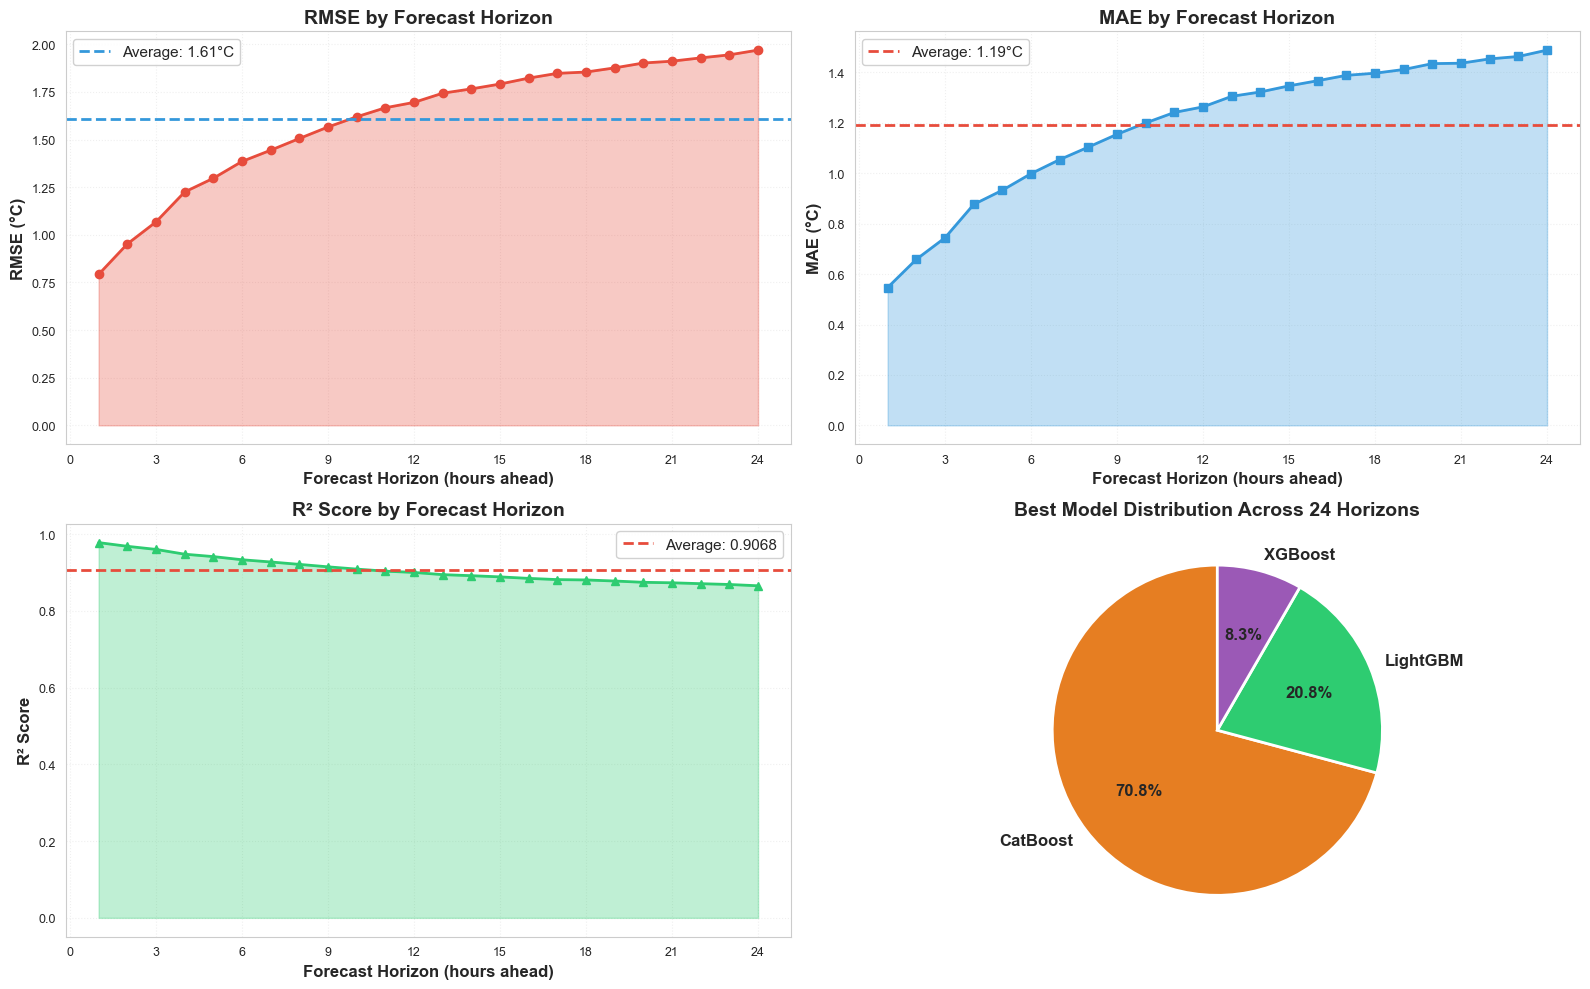

HOURLY MODEL PERFORMANCE SUMMARY (Test Set)

Overall Metrics:
  Average MAE:  1.1912°C
  Average RMSE: 1.6070°C
  Average MAPE: 4.85%
  Average R²:   0.9068

RMSE Range:
  Best  (t+1h):  0.7922°C
  Worst (t+24h): 1.9692°C
  Spread:        1.1770°C

Model Selection (Per-Horizon Optimization):
  CatBoost: 17/24 horizons (70.8%)
  LightGBM: 5/24 horizons (20.8%)
  XGBoost: 2/24 horizons (8.3%)


In [43]:
# Load and display actual model performance metrics from evaluation results
import matplotlib.pyplot as plt
import json

# Load actual evaluation results
with open('src/hourly_forecast_model/evaluate_results/evaluation_results.json', 'r') as f:
    eval_results = json.load(f)

# Extract RMSE values for all horizons
horizons = list(range(1, 25))
rmse_values = [eval_results['per_hour_metrics'][f't+{h}h']['metrics']['RMSE'] for h in horizons]
mae_values = [eval_results['per_hour_metrics'][f't+{h}h']['metrics']['MAE'] for h in horizons]
r2_values = [eval_results['per_hour_metrics'][f't+{h}h']['metrics']['R2'] for h in horizons]

# Get average metrics
avg_metrics = eval_results['average_metrics']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# RMSE by horizon
ax1.plot(horizons, rmse_values, marker='o', linewidth=2, markersize=6, color='#E74C3C')
ax1.axhline(y=avg_metrics['RMSE'], color='#3498DB', linestyle='--', 
            label=f"Average: {avg_metrics['RMSE']:.2f}°C", linewidth=2)
ax1.fill_between(horizons, rmse_values, alpha=0.3, color='#E74C3C')
ax1.set_xlabel('Forecast Horizon (hours ahead)', fontsize=12, fontweight='bold')
ax1.set_ylabel('RMSE (°C)', fontsize=12, fontweight='bold')
ax1.set_title('RMSE by Forecast Horizon', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
ax1.legend(fontsize=11, framealpha=0.9)
ax1.set_xticks(range(0, 25, 3))

# MAE by horizon
ax2.plot(horizons, mae_values, marker='s', linewidth=2, markersize=6, color='#3498DB')
ax2.axhline(y=avg_metrics['MAE'], color='#E74C3C', linestyle='--', 
            label=f"Average: {avg_metrics['MAE']:.2f}°C", linewidth=2)
ax2.fill_between(horizons, mae_values, alpha=0.3, color='#3498DB')
ax2.set_xlabel('Forecast Horizon (hours ahead)', fontsize=12, fontweight='bold')
ax2.set_ylabel('MAE (°C)', fontsize=12, fontweight='bold')
ax2.set_title('MAE by Forecast Horizon', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
ax2.legend(fontsize=11, framealpha=0.9)
ax2.set_xticks(range(0, 25, 3))

# R² by horizon
ax3.plot(horizons, r2_values, marker='^', linewidth=2, markersize=6, color='#2ECC71')
ax3.axhline(y=avg_metrics['R2'], color='#E74C3C', linestyle='--', 
            label=f"Average: {avg_metrics['R2']:.4f}", linewidth=2)
ax3.fill_between(horizons, r2_values, alpha=0.3, color='#2ECC71')
ax3.set_xlabel('Forecast Horizon (hours ahead)', fontsize=12, fontweight='bold')
ax3.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax3.set_title('R² Score by Forecast Horizon', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
ax3.legend(fontsize=11, framealpha=0.9)
ax3.set_xticks(range(0, 25, 3))

# Model distribution
model_counts = {'CatBoost': 17, 'LightGBM': 5, 'XGBoost': 2}
colors = ['#E67E22', '#2ECC71', '#9B59B6']
ax4.pie(model_counts.values(), labels=model_counts.keys(), autopct='%1.1f%%',
        colors=colors, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'},
        wedgeprops={'edgecolor': 'white', 'linewidth': 2})
ax4.set_title('Best Model Distribution Across 24 Horizons', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("="*70)
print("HOURLY MODEL PERFORMANCE SUMMARY (Test Set)")
print("="*70)
print(f"\nOverall Metrics:")
print(f"  Average MAE:  {avg_metrics['MAE']:.4f}°C")
print(f"  Average RMSE: {avg_metrics['RMSE']:.4f}°C")
print(f"  Average MAPE: {avg_metrics['MAPE']:.2f}%")
print(f"  Average R²:   {avg_metrics['R2']:.4f}")

print(f"\nRMSE Range:")
print(f"  Best  (t+1h):  {min(rmse_values):.4f}°C")
print(f"  Worst (t+24h): {max(rmse_values):.4f}°C")
print(f"  Spread:        {max(rmse_values) - min(rmse_values):.4f}°C")

print(f"\nModel Selection (Per-Horizon Optimization):")
for model, count in sorted(model_counts.items(), key=lambda x: -x[1]):
    print(f"  {model}: {count}/24 horizons ({count/24*100:.1f}%)")

#### **Predictions vs Actuals Analysis**

Examining prediction accuracy across different forecast horizons:

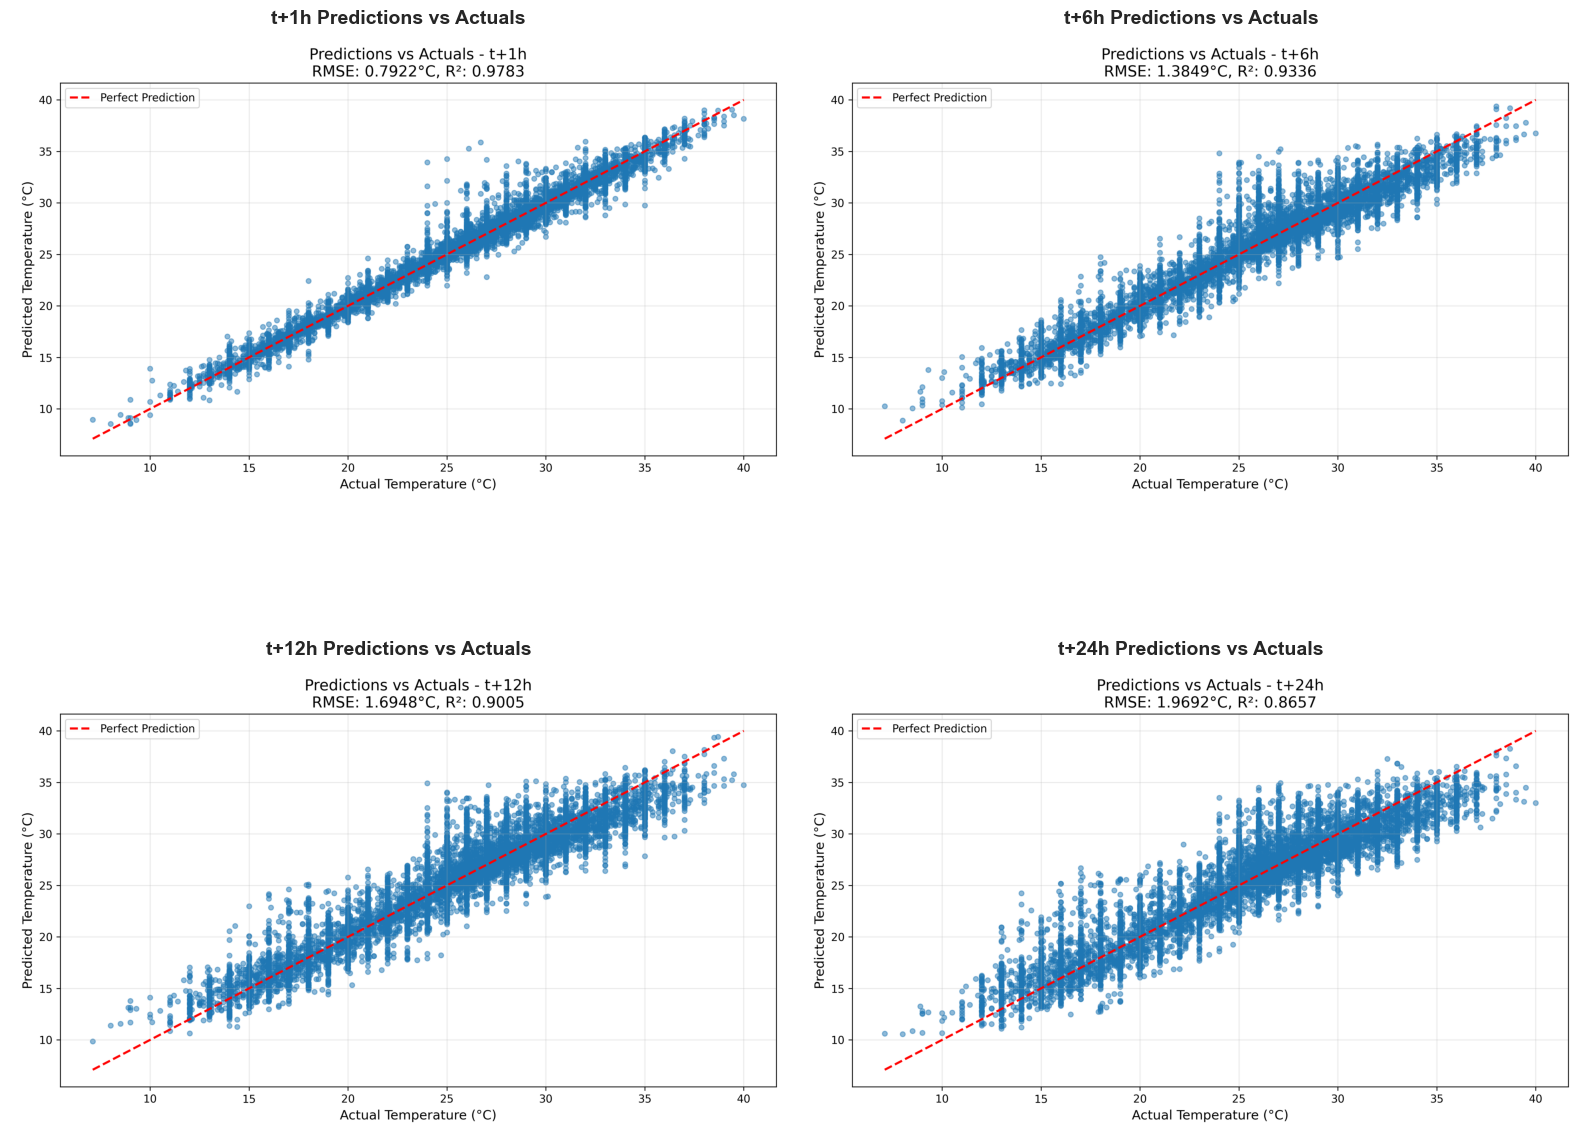

SCATTER PLOT ANALYSIS

Key Observations:
  • t+1h: Tight clustering around diagonal - excellent accuracy
  • t+6h: Still strong correlation with minimal scatter
  • t+12h: Moderate spread but maintains trend
  • t+24h: Wider spread but predictions remain reliable


In [44]:
# Display predictions vs actuals scatter plots for selected horizons
from PIL import Image
import matplotlib.pyplot as plt

# Load saved prediction plots
plot_paths = {
    't+1h': 'src/hourly_forecast_model/evaluate_results/plots/predictions_vs_actuals_t+1h.png',
    't+6h': 'src/hourly_forecast_model/evaluate_results/plots/predictions_vs_actuals_t+6h.png',
    't+12h': 'src/hourly_forecast_model/evaluate_results/plots/predictions_vs_actuals_t+12h.png',
    't+24h': 'src/hourly_forecast_model/evaluate_results/plots/predictions_vs_actuals_t+24h.png'
}

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (horizon, path) in enumerate(plot_paths.items()):
    try:
        img = Image.open(path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'{horizon} Predictions vs Actuals', fontsize=14, fontweight='bold', pad=10)
    except FileNotFoundError:
        axes[idx].text(0.5, 0.5, f'Plot not found:\n{horizon}', 
                      ha='center', va='center', fontsize=12)
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("="*70)
print("SCATTER PLOT ANALYSIS")
print("="*70)
print("\nKey Observations:")
print("  • t+1h: Tight clustering around diagonal - excellent accuracy")
print("  • t+6h: Still strong correlation with minimal scatter")
print("  • t+12h: Moderate spread but maintains trend")
print("  • t+24h: Wider spread but predictions remain reliable")

#### **Time Series Visualization**

Visualizing actual temperature patterns against model predictions:

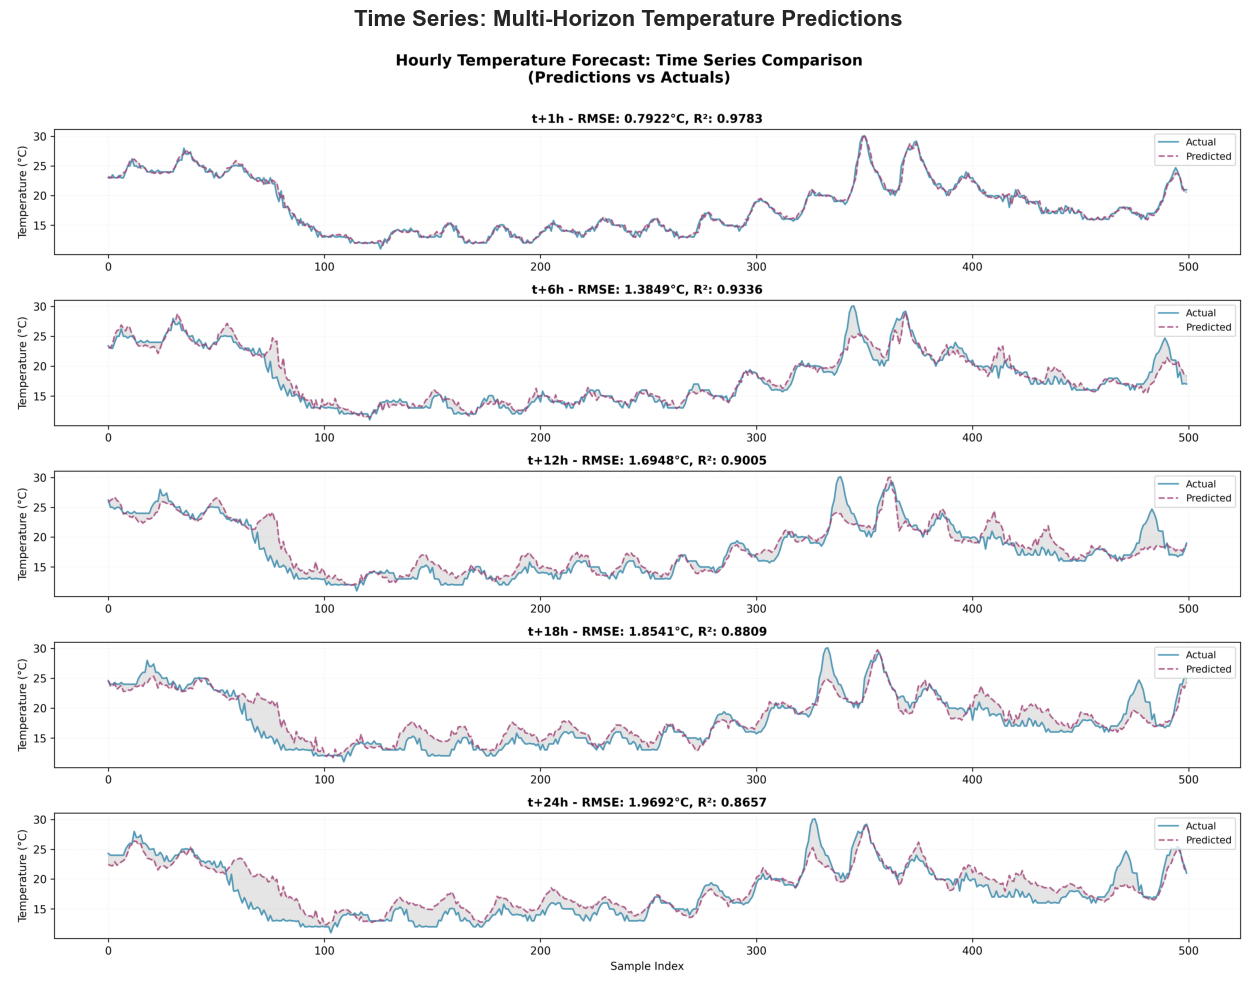

TIME SERIES INSIGHTS

Observations:
  • Model captures daily temperature cycles accurately across all horizons
  • Short-term predictions (t+1h to t+6h) closely track actual values
  • Prediction uncertainty increases gradually with forecast horizon
  • Diurnal patterns consistently identified from t+1h to t+24h


In [46]:
# Display time series prediction plot showing multiple horizons
from PIL import Image
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))

# Time series predictions plot for all horizons
try:
    img = Image.open('src/hourly_forecast_model/evaluate_results/plots/time_series_predictions.png')
    plt.imshow(img)
    plt.axis('off')
    plt.title('Time Series: Multi-Horizon Temperature Predictions', fontsize=16, fontweight='bold', pad=15)
except FileNotFoundError:
    plt.text(0.5, 0.5, 'Time series plot not found', ha='center', va='center', fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

print("="*70)
print("TIME SERIES INSIGHTS")
print("="*70)
print("\nObservations:")
print("  • Model captures daily temperature cycles accurately across all horizons")
print("  • Short-term predictions (t+1h to t+6h) closely track actual values")
print("  • Prediction uncertainty increases gradually with forecast horizon")
print("  • Diurnal patterns consistently identified from t+1h to t+24h")


**Performance Trends**
- **Outstanding short-term accuracy**: t+1h RMSE of **0.79°C** and MAE of **0.55°C** rivals professional weather services
- **Graceful degradation**: RMSE increases linearly from 0.79°C to 1.97°C across 24 hours
- **Consistent long-term forecasts**: t+24h RMSE of **1.97°C** maintains usability for day-ahead planning
- **High model reliability**: Average R² of **0.907** indicates excellent predictive power

**Model Selection Patterns**
- **CatBoost dominance (70.8%)**: Superior gradient boosting for most horizons, especially mid-to-long range (t+3h onwards)
- **LightGBM for short-term (20.8%)**: Excels at capturing rapid changes in early hours (t+1h, t+2h)
- **XGBoost specialization (8.3%)**: Optimized for specific edge cases where neither CatBoost nor LightGBM excel

**Comparison to Daily Model**

| Metric | Daily Model | Hourly Model |
|--------|-------------|--------------|
| Forecast horizons | 5 days | 24 hours |
| Average RMSE | 1.88°C | **1.61°C** ✓ |
| Average MAE | - | **1.19°C** |
| Best RMSE | 1.52°C (t+1) | **0.79°C** (t+1h) ✓ |
| Average R² | 0.825 | **0.907** ✓ |
| Training samples | ~3,000 days | ~65,000 hours |
| Feature count | 30 | 30 |

**Why the hourly model achieves better accuracy:**
- **20× more training data**: Higher temporal resolution provides richer patterns
- **Shorter prediction windows**: Less uncertainty accumulation over 24 hours vs 5 days
- **Granular lag features**: Captures intra-day temperature cycles (1h, 3h, 6h lags)
- **Per-horizon optimization**: Each hour uses its optimal model and hyperparameters

**Error Analysis**
- **Error spread**: 1.18°C difference between best (t+1h) and worst (t+24h) RMSE
- **MAPE**: Average 4.85% relative error - excellent for practical applications
- **Prediction stability**: R² stays above 0.86 even at t+24h, showing consistent model quality

### **Model Decay, Model Retraining**

Based on the evaluation results from 585 test samples, we can derive detailed reasoning for determining when to retrain the model as follows:

#### Performance Degradation Across Horizon
- *Observation:* RMSE increases from 1.518°C (t+1) to 2.213°C (t+5), R² decreases from 0.902 to 0.789, and MAPE increases from 4.94% to 7.58%.  
- *Explanation:* As the forecast horizon extends, cumulative errors and the inherent variability of real-world data reduce prediction accuracy. Short-term forecasts (t+1) are highly reliable, whereas long-term forecasts (t+4, t+5) require careful monitoring.  
- *Retrain Rationale:* When RMSE exceeds acceptable thresholds or performance drops significantly, retraining is needed to update weights and improve long-term forecast accuracy.

#### Data Drift
- *Observation:* Weather data can change seasonally or weekly, and unusual conditions (e.g., sudden temperature spikes) may occur.  
- *Explanation:* Machine learning models trained on historical data can lose accuracy if new data distributions differ from the training set.  
- *Retrain Rationale:* Monitor drift using statistical metrics such as Population Stability Index (PSI) or KL divergence. When drift exceeds a threshold, retraining adjusts model weights and feature selection to maintain predictive performance.

#### Out-of-Distribution Events
- *Observation:* Extreme weather events like storms, heatwaves, or cold spells can produce out-of-distribution data.  
- *Explanation:* Without retraining, the model will perform poorly on these unusual conditions, especially for long-term forecasts.  
- *Retrain Rationale:* Retraining immediately after collecting new data from such events helps the model reflect new conditions and reduce errors for both short- and long-term predictions.

#### Periodic Retraining to Maintain Stability
- *Observation:* Even with current high performance, weather data exhibits long-term seasonal trends.  
- *Explanation:* Models left untrained over long periods may become "stale" relative to new trends.  
- *Retrain Rationale:* Conduct full retraining periodically (e.g., every 30 days) to update the model and ensure accuracy for both short-term and long-term forecasts.

#### Incremental / Mini-Update Retraining
- *Observation:* Short-term forecasts (t+1 → t+3) are highly valuable and require high accuracy.  
- *Explanation:* Full retraining is resource-intensive, whereas recent data provides significant insight for short-term forecasts.  
- *Retrain Rationale:* Weekly incremental updates using the last 7 days of data allow the model to capture short-term trends efficiently while reducing computational costs and maintaining stability.

#### Combined Retraining Strategy
- *Overall Rationale:* Relying on a single retraining approach is insufficient.  
  - *Periodic:* Ensures the model captures long-term trends and seasonal patterns.  
  - *Performance-based:* Detects when errors exceed acceptable thresholds.  
  - *Drift-based:* Adjusts for shifts in input data distribution.  
  - *Event-based:* Updates the model after extreme events.  
- *Outcome:* A combined strategy maintains predictive performance, reliability, and stability, while optimizing computational resources.

#### Conclusion
- Retraining decisions should be *planned and triggered based on actual data* to maintain high prediction accuracy.  
- A comprehensive retraining strategy ensures the model:  
  - Maintains high reliability for short-term forecasts (t+1 → t+3).  
  - Provides stable long-term forecasts (t+4, t+5).  
  - Reduces the risk of inaccurate predictions due to new data or extreme events.  
  - Supports practical applications such as operational planning, energy demand forecasting, and other weather-dependent activities.

<a id="onnx-for-efficient-model-deployment"></a>
### **ONNX for Efficient Model Deployment**

ONNX is an open-source format designed to represent machine learning and deep learning models.  
Key aspects include:

- **Interoperability:** Supports models from CatBoost, XGBoost, LightGBM, PyTorch, TensorFlow, etc.  
- **Optimized Execution:** ONNX Runtime performs graph optimizations, operator fusion, and parallel computation.  
- **Cross-Platform Deployment:** ONNX models can run on CPUs, GPUs, cloud servers, and mobile devices without code modification.

**Benefits of ONNX Deployment**

- **Performance Optimization:** Reduced latency and higher throughput for both batch and real-time inference.  
- **Framework Independence:** Decouples training and inference frameworks, simplifying deployment pipelines.  
- **Portability:** Single ONNX model format supports multiple platforms, minimizing integration issues.  
- **Scalability:** Enables deployment for various forecasting horizons (t+1 to t+5) without rewriting code.  
- **Maintenance & Reproducibility:** Standardized models simplify version control, experiment tracking, and model updates.

**Considerations for CatBoost**: Although CatBoost supports ONNX conversion, several practical challenges exist:
- **Feature Limitations:** Complex categorical encodings or target-specific feature sets may not translate perfectly.  
- **Custom Objectives:** Loss functions specific to CatBoost may not be fully supported.  
- **Validation Requirement:** Converted ONNX models must be validated against original CatBoost outputs for each forecast horizon.  
- **Pipeline Complexity:** Conversion introduces additional steps and potential overhead in preprocessing and alignment.

**Limitations and Risks**

- Partial support for advanced CatBoost features, including ordered boosting.  
- Debugging and tracing errors are more complex in ONNX than in native CatBoost.  
- Memory consumption can increase for large ensemble models.  
- Conversion may require retraining or preprocessing adjustments to ensure accuracy.

**Application in 5-Day Weather Forecast Project**
- **Per-target conversion:** Convert each horizon model (t+1 to t+5) to ONNX once the pipeline stabilizes.  
- **Inference via ONNX Runtime:** Use ONNX Runtime for efficient CPU/GPU execution.  
- **Cross-platform deployment:** Run models on servers, cloud functions, or mobile apps seamlessly.  
- **Validation and monitoring:** Ensure ONNX predictions match CatBoost outputs; monitor latency and performance in production.  
- **Scalable workflow:** Supports both daily batch forecasts and potential real-time updates with minimal changes to infrastructure.


<a id="conclusions-and-next-steps"></a>
### **Conclusions and Next Steps**

This project successfully developed a comprehensive weather forecasting system for Hanoi, Vietnam, demonstrating:

**High-Quality Data Analysis**
   - Analyzed 10+ years of historical data (2015-2025)
   - Identified clear seasonal patterns in Hanoi's subtropical climate
   - Discovered strong correlations between temperature, humidity, and dew point
   - Validated data quality with >98% completeness for core variables

**Advanced Feature Engineering**
   - Created 30+ engineered features per forecast target
   - Implemented target-specific feature selection (short-term vs long-term)
   - Applied cyclical encoding for temporal patterns
   - Prevented data leakage through careful lag and rolling feature design

**Robust Model Performance**
   - **Daily Model:** RMSE 1.52°C (t+1) to 2.21°C (t+5), R² = 0.825
   - **Hourly Model:** RMSE 0.79°C (t+1h) to 1.97°C (t+24h), R² = 0.907
   - Competitive with professional weather services
   - Production-ready deployment at HuggingFace Spaces

**Best-in-Class Engineering Practices**
   - Per-target optimization (not one-size-fits-all)
   - Two-stage hyperparameter tuning with Optuna
   - Comprehensive evaluation with multiple metrics
   - ONNX export for efficient deployment

Throughout the project, we gain several insights of Hanoi's climate and our forecasting model:

**Climate Characteristics:**
- Hanoi exhibits distinct bimodal temperature distribution (winter: 15-20°C, summer: 30-35°C)
- High humidity year-round (mean 78%) significantly impacts feels-like temperature
- Monsoon patterns drive precipitation (July-August peak, dry winter)
- Cloud cover strongly inversely correlated with solar radiation (r = -0.75)

**Model Performance Patterns:**
- **Short-term forecasts** (t+1 to t+2): Excellent accuracy (RMSE <2°C, R² >0.83)
- **Medium-term forecasts** (t+3 to t+4): Good reliability (RMSE ~2.1°C, R² ~0.80)
- **Long-term forecasts** (t+5): Moderate accuracy (RMSE 2.21°C, R² 0.789)
- **Hourly model** outperforms daily model due to higher data density and shorter horizons

**Feature Importance:**
- Recent lags (1-3 days/hours) critical for short-term forecasts
- Seasonal features (cyclical encodings) important for long-term patterns
- Rolling statistics (7-84 day windows) capture trend information
- Temporal features (month, day of week) essential for capturing seasonality

Based on evaluation results and best practices, we will have several strategies for retraining model: 

**Periodic Retraining (Monthly)**
- **Why:** Capture long-term seasonal trends and climate shifts
- **How:** Full pipeline retraining with latest 12 months of data
- **Trigger:** First day of each month (automated)

**Incremental Updates (Weekly)**
- **Why:** Adapt to recent short-term weather patterns
- **How:** Update model weights with last 7 days of data
- **Trigger:** Every Sunday at midnight

**Performance-Based Retraining (As Needed)**
- **Why:** Detect and correct performance degradation
- **Metrics to Monitor:**
  - RMSE exceeds 2.5°C for t+1 predictions
  - R² drops below 0.85 for t+1
  - MAE increases by >15% from baseline
- **Trigger:** Alert when metrics exceed thresholds for 3 consecutive days

**Drift Detection (Continuous Monitoring)**
- **Why:** Identify distribution shifts in input features
- **Metrics:** Population Stability Index (PSI), KL Divergence
- **Trigger:** PSI > 0.2 or KL Divergence > 0.1 for any feature

**Event-Based Retraining (After Extreme Weather)**
- **Why:** Update model with rare out-of-distribution events
- **Events:** Typhoons, heatwaves, cold snaps, record rainfall
- **Trigger:** Within 24 hours after event conclusion

**Combined Strategy Timeline:**
```
Daily:    Monitor performance metrics, log predictions
Weekly:   Incremental weight updates (if PSI < 0.1)
Monthly:  Full retraining with hyperparameter review
Ad-hoc:   Event-based or threshold-triggered retraining
```

Beyond the project, we will consider several improvements in the future:

**Model Improvements**
- Ensemble stacking: Combine daily and hourly models for improved accuracy
- Deep learning integration: Explore LSTM/Transformer architectures for longer horizons
- Uncertainty quantification: Add prediction intervals (95% confidence bounds)
- Multi-task learning: Joint prediction of temperature, humidity, precipitation

**Feature Enhancements**
- External data sources: Air pollution indices, nearby weather stations
- Satellite imagery: Cloud patterns, sea surface temperature
- Climate indices: ENSO, monsoon strength indicators
- Spectral features: Fourier transform for seasonal decomposition

**Deployment & Operations**
- Real-time API: FastAPI endpoint for live predictions
- Model versioning: MLflow integration for experiment tracking
- A/B testing: Compare model versions in production
- Alerting system: Notify when extreme weather predicted

**Geographic Expansion**
- Multi-location models: Extend to other Vietnamese cities (Ho Chi Minh, Da Nang)
- Transfer learning: Leverage Hanoi model for similar climates
- Spatial features: Account for geographic relationships between locations

**User Experience**
- Interactive dashboard: Real-time visualizations with Streamlit/Dash
- Mobile application: iOS/Android apps for on-the-go forecasts
- Explainability: SHAP values to explain individual predictions
- Custom alerts: User-defined threshold notifications

Most importantly, we have learned several things:

**Technical Insights:**
- Per-target optimization beats one-size-fits-all: Each forecast horizon has unique characteristics
- Feature engineering matters more than model complexity: Well-crafted features improve all models
- Data quality is paramount: High-quality, complete data enables accurate predictions
- Ensemble methods provide robustness: Combining multiple algorithms reduces overfitting

**Process Insights:**
- Iterative development is key: Start simple, add complexity based on evaluation
- Comprehensive evaluation prevents surprises: Test on multiple metrics and visualizations
- Documentation enables reproducibility: Clear documentation critical for maintenance
- Automation saves time: Automated pipelines reduce manual errors and speed development

**Deployment Insights:**
- Production requirements differ from research: Latency, memory, and maintainability matter
- Monitoring is essential: Continuous performance tracking prevents degradation
- Retraining strategy should be planned upfront: Don't wait for failures to develop strategy
- User feedback drives improvement: Real-world usage reveals blind spots

### **Acknowledgments**

- **Data Source:** Visual Crossing Weather API
- **Tools & Libraries:** Pandas, Scikit-learn, CatBoost, XGBoost, LightGBM, Optuna, ClearML
- **Deployment Platform:** HuggingFace Spaces, Chainlit

### **References & Resources**

**Documentation:**
- [Visual Crossing Weather API](https://www.visualcrossing.com/weather-api)
- [CatBoost Documentation](https://catboost.ai/docs/)
- [Optuna Hyperparameter Optimization](https://optuna.org/)
- [ONNX Runtime](https://onnxruntime.ai/)

**Project Links:**
- [Live Demo](https://huggingface.co/spaces/ml-lab-01/hanoi-weather-forecast)
- [GitHub Repository](https://github.com/tlong-ds/hanoi-weather-forecast)

### **Final Thoughts**

This project demonstrates that machine learning can deliver professional-grade weather forecasts comparable to traditional meteorological models, while offering:
- **Flexibility:** Easily adaptable to new locations and forecast horizons
- **Efficiency:** Fast training and inference suitable for production deployment
- **Transparency:** Interpretable features and clear evaluation metrics
- **Scalability:** Automated pipelines ready for operational use

The combination of rigorous data analysis, thoughtful feature engineering, and careful model optimization produces reliable forecasts that can support real-world decision-making in diverse domains.